# Линейная регрессия в Scikit-Learn

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Будем использовать те же данные, что и в случае построения простой линейной регрессии.

In [3]:
df = pd.read_csv('Advertising.csv')
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


### Постановка вопроса
Раньше мы искали ответ на вопрос - **Есть ли связь между общими расходами на рекламу и продажами?**, а также пытались предсказывать продажи на основе заданного значения общего бюджета на рекламу. Теперь давайте зададим более широкий вопрос - **Какова связь между каналами рекламы (ТВ, радио, газеты) и продажами?**

### Несколько признаков (N-мерное пространство)

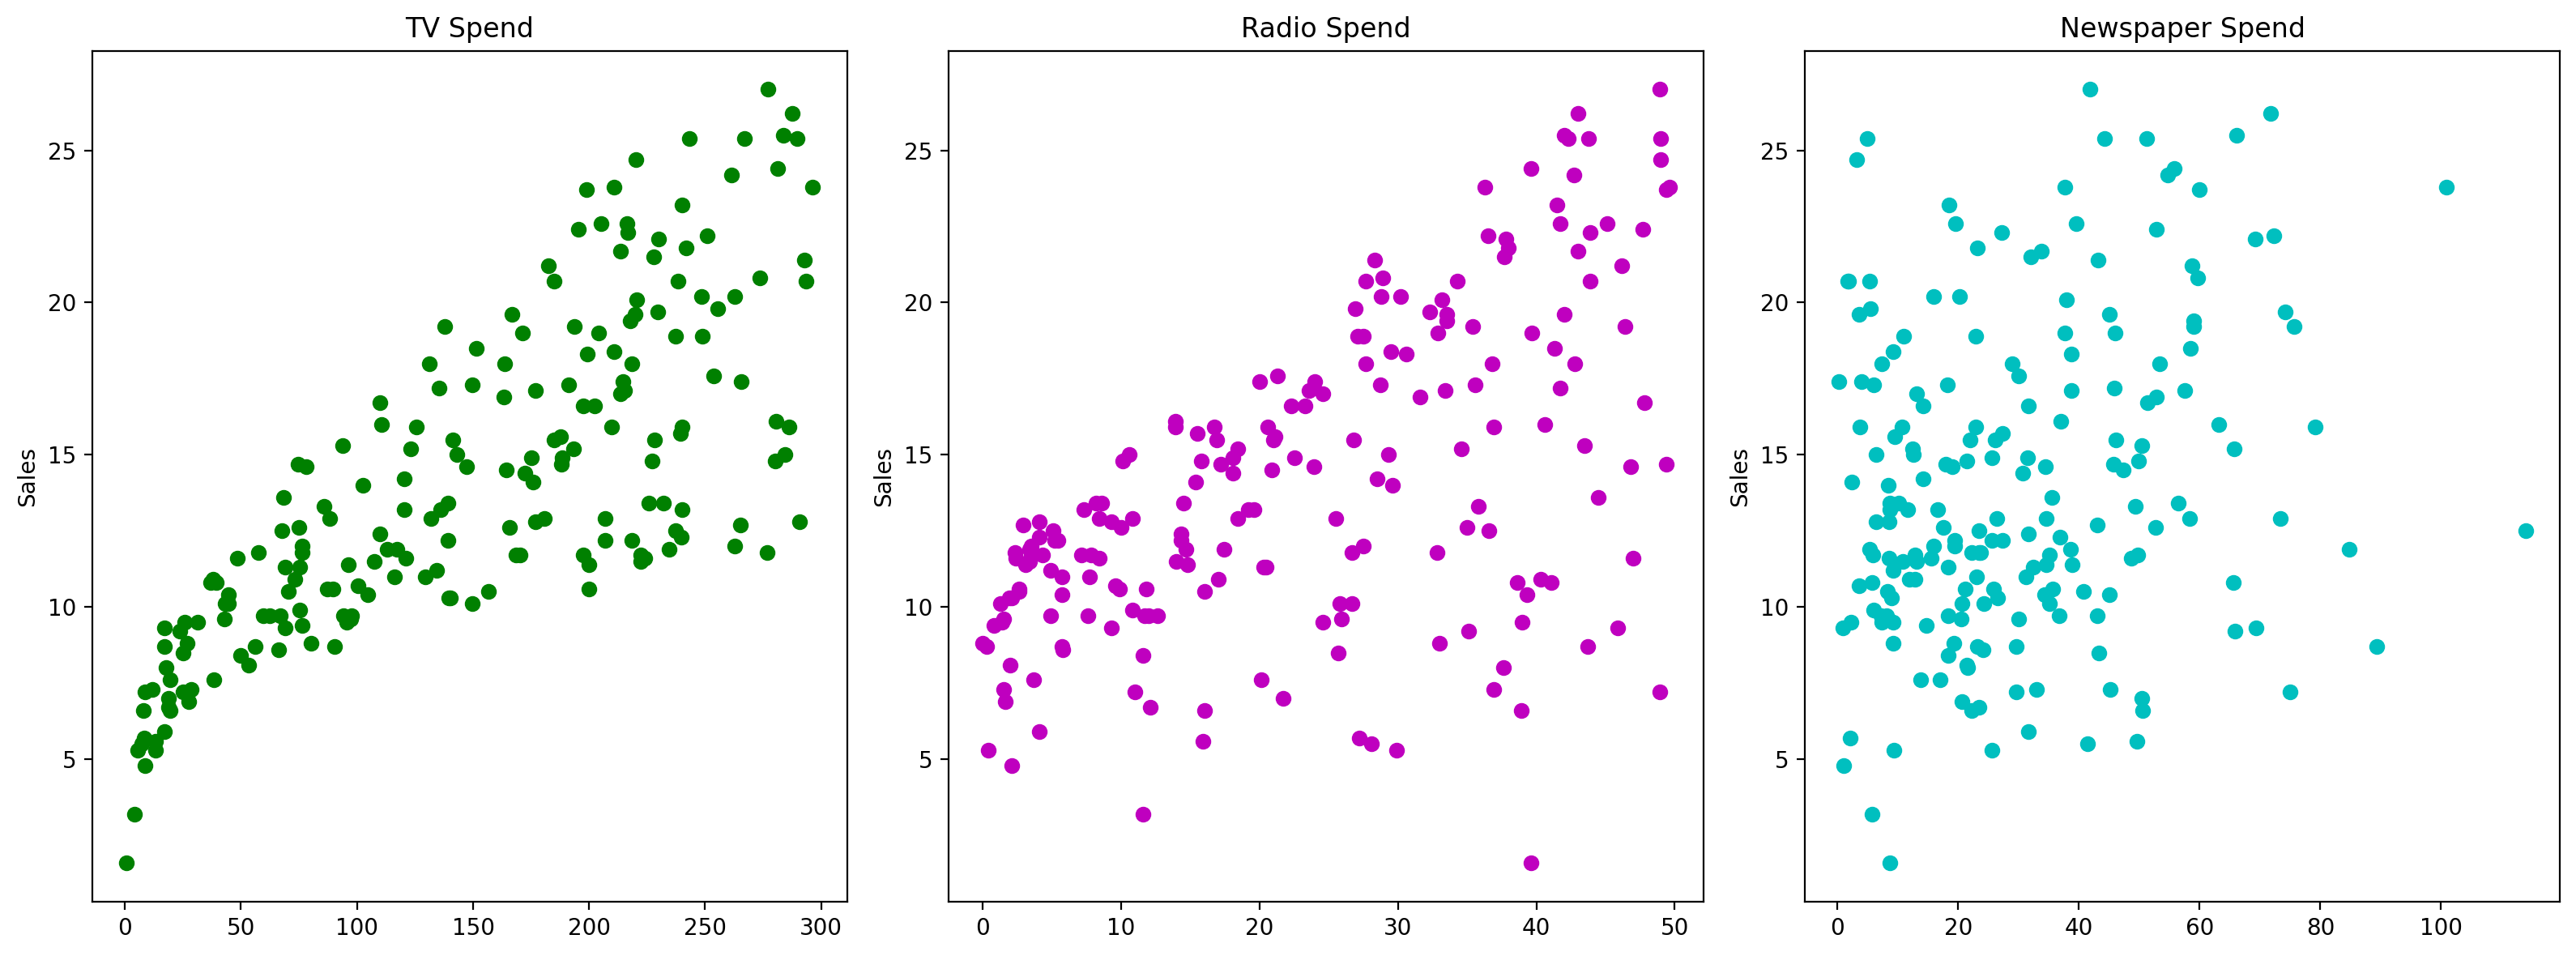

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), dpi=200)

axes[0].plot(df['TV'], df['sales'], 'go')
axes[0].set_ylabel('Sales')
axes[0].set_title('TV Spend')

axes[1].plot(df['radio'], df['sales'], 'mo')
axes[1].set_ylabel('Sales')
axes[1].set_title('Radio Spend')

axes[2].plot(df['newspaper'], df['sales'], 'co')
axes[2].set_ylabel('Sales')
axes[2].set_title('Newspaper Spend')

plt.tight_layout()
plt.show()

Для ТВ и радио - наблюдается четкая линейная зависимость, а для газет несколько размытая картина.

*Посмотрим на связи между признаками*

<Figure size 3200x1200 with 0 Axes>

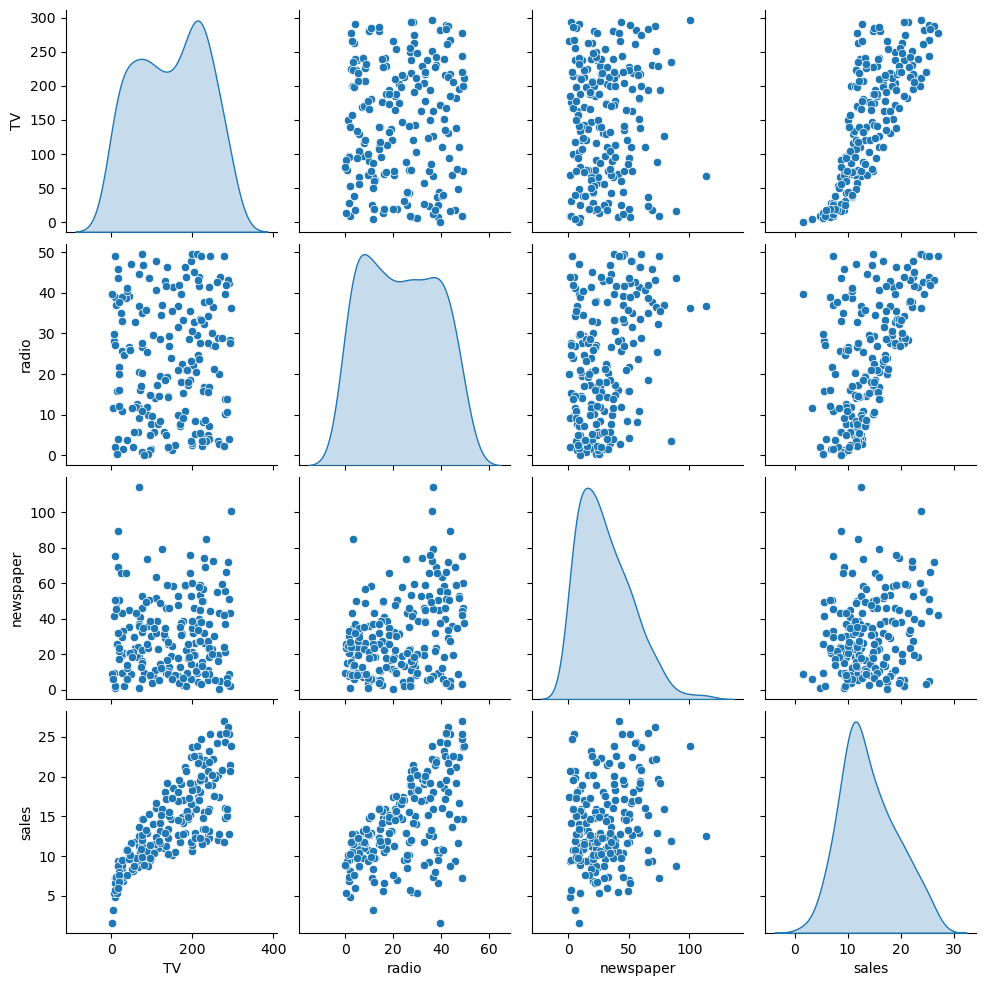

In [8]:
plt.figure(figsize=(16, 6), dpi=200)
sns.pairplot(df, diag_kind='kde')
plt.show()

---
---

## Введение в Scikit-Learn
Для начала разобьем данные на признаки и целевую переменную

In [10]:
# Так как признаки - это все колонки без целевой переменной,
# можно быстро получить их следующим образом
X = df.drop('sales', axis=1)
y = df['sales']

In [12]:
X

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4
...,...,...,...
195,38.2,3.7,13.8
196,94.2,4.9,8.1
197,177.0,9.3,6.4
198,283.6,42.0,66.2


In [14]:
y

0      22.1
1      10.4
2       9.3
3      18.5
4      12.9
       ... 
195     7.6
196     9.7
197    12.8
198    25.5
199    13.4
Name: sales, Length: 200, dtype: float64

## Разбиение на обучающую и тестовую выборки - Train | Test Split

In [16]:
from sklearn.model_selection import train_test_split

In [18]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

Прежде чем данные буду разбиты на обучающие и тестовые наборы, эти данные будут перемешанны между собой случайным образом. Далее в тестовый набор будет отложен случайные ...% строк.

`random_state` - парметр, который нужен для воспроизводимости результатов. Число выбирается произвольно, главное, чтобы позднее было указано точно такое же число, если потребуется воспроизвести предыдущие результаты. Например - если применяется несколько разных алгоритмов, а затем сравниваются их результаты работы между собой. Чтобы сделать такое сравнение корректно - на вход этим алгоритмам будут подаваться одни и те же разбиения на обучающие и тестовые наборы данных. Тем самым, можно избежать ситуации когда один из алгоритмов сработал лучше только потому, что ему попалось более удачное разбиение данных.

In [20]:
# random_state: 
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
len(df)

200

In [24]:
X_train

,TV,radio,newspaper
169,284.3,10.6,6.4
97,184.9,21.0,22.0
31,112.9,17.4,38.6
12,23.8,35.1,65.9
35,290.7,4.1,8.5
...,...,...,...
106,25.0,11.0,29.7
14,204.1,32.9,46.0
92,217.7,33.5,59.0
179,165.6,10.0,17.6


**Важно: в датафреймах сохранились номера индексов из исходного датафрейма!** С их помощью можно найти соответствующие значения в целевой переменной. Т.е. мы сможем сопоставлять соответствующие строки между X_train и y_train, а также между X_test и y_test.

In [26]:
y_train

169    15.0
97     15.5
31     11.9
12      9.2
35     12.8
       ... 
106     7.2
14     19.0
92     19.4
179    12.6
102    14.8
Name: sales, Length: 140, dtype: float64

**В y_train содержатся только значения целевой переменной**

In [28]:
X_test

,TV,radio,newspaper
95,163.3,31.6,52.9
15,195.4,47.7,52.9
30,292.9,28.3,43.2
158,11.7,36.9,45.2
128,220.3,49.0,3.2
115,75.1,35.0,52.7
69,216.8,43.9,27.2
170,50.0,11.6,18.4
174,222.4,3.4,13.1
45,175.1,22.5,31.5


In [30]:
y_test

95     16.9
15     22.4
30     21.4
158     7.3
128    24.7
115    12.6
69     22.3
170     8.4
174    11.5
45     14.9
66      9.5
182     8.7
165    11.9
78      5.3
186    10.3
177    11.7
56      5.5
152    16.6
82     11.3
68     18.9
124    19.7
16     12.5
148    10.9
93     22.2
65      9.3
60      8.1
84     21.7
67     13.4
125    10.6
132     5.7
9      10.6
18     11.3
55     23.7
75      8.7
150    16.1
104    20.7
135    11.6
137    20.8
164    11.9
76      6.9
79     11.0
197    12.8
38     10.1
24      9.7
122    11.6
195     7.6
29     10.5
19     14.6
143    10.4
86     12.0
114    14.6
173    11.7
5       7.2
126     6.6
117     9.4
73     11.0
140    10.9
98     25.4
172     7.6
96     11.7
Name: sales, dtype: float64

---
---

## Создание модели (в терминах Scikit-Learn это Model Estimator)
**Для начала импортируем класс модели**

In [32]:
from sklearn.linear_model import LinearRegression

**Создаем экземпляр модели с параметрами**

In [34]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  copy_X : bool, default=True
 |      If True, X will be copied; else, it may be overwritten.
 |  
 |  n_jobs : int, default=None
 |      The number of jobs to use for the computation. This will only provide
 |  

In [36]:
# Переменную для экземпляра модели можно назвать как угодно
model = LinearRegression()

## Выполняем обучение (Fit/Train) модели на обучающих данных
**Обучение следует проводить не на всех данных, а только на обучающих данных; тогда будет возможность оценить работу модели на тестовых данных, чтобы проверить её способность работать с неизвестными данными в будущем.**

In [38]:
model.fit(X_train, y_train)

LinearRegression()

In [40]:
# Эти значения сравниваются с y_test
model.predict(X_test)

array([16.5653963 , 21.18822792, 21.55107058, 10.88923816, 22.20231988,
       13.35556872, 21.19692502,  7.35028523, 13.27547079, 15.12449511,
        9.01443026,  6.52542825, 14.30205991,  8.97026042,  9.45679576,
       12.00454351,  8.91549403, 16.15619251, 10.29582883, 18.72473553,
       19.76821818, 13.77469028, 12.49638908, 21.53501762,  7.60860741,
        5.6119801 , 20.91759483, 11.80627665,  9.08076637,  8.51412012,
       12.17604891,  9.9691939 , 21.73008956, 12.77770578, 18.1011362 ,
       20.07590796, 14.26202556, 20.93826535, 10.83938827,  4.38190607,
        9.51332406, 12.40486324, 10.17045434,  8.09081363, 13.16388427,
        5.2243552 ,  9.28893833, 14.09330719,  8.69024497, 11.66119763,
       15.71848432, 11.63156862, 13.35360735, 11.1531472 ,  6.33636845,
        9.76157954,  9.4195714 , 24.25516546,  7.69519137, 12.15317572])

---
---

## Оценка работы модели на тестовых данных
### Метрики

Для регрессионных задач наиболее часто используются следующие три метрики:

**Средняя абсолютная ошибка - Mean Absolute Error** (MAE) - усредняет абсолютные значения ошибок:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Среднеквадратическая ошибка - Mean Squared Error** (MSE) - усредняет квадраты ошибок:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Среднеквадратическое отклонение - Root Mean Squared Error** (RMSE) - квадратный корень от среднеквадратической ошибки:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Сравнение метрик:

- **MAE** проще всего понять - это просто средняя ошибка.
- **MSE** более популярнее MAE, потому что MSE больше "наказывает" большие ошибки, и обычно это более полезно в прикладных задачах.
- **RMSE** даже ещё более популярна, чем MSE, потому что RMSE измеряется в тех же единицах, что и "y".

Все эти метрики являются **функциями потери (loss functions)**, потому что мы стремимся уменьшить их.

### Вычисляем производительность модели на тестовых данных
Чтобы корректно оценить работу модели, мы вычисляем метрики на тестовом наборе данных(это те данные, которые модель никогда не видела в процессе обучения).

In [42]:
X_test.head()

,TV,radio,newspaper
95,163.3,31.6,52.9
15,195.4,47.7,52.9
30,292.9,28.3,43.2
158,11.7,36.9,45.2
128,220.3,49.0,3.2


In [44]:
y_test.head()

95     16.9
15     22.4
30     21.4
158     7.3
128    24.7
Name: sales, dtype: float64

In [46]:
# Мы передаём только тестовые данные
# Модель делает предсказания - значения y с крышкой
# Теперь мы можем сравнить предсказанные значения с известными нам истинными значениями y
test_predictions = model.predict(X_test)

In [48]:
test_predictions

array([16.5653963 , 21.18822792, 21.55107058, 10.88923816, 22.20231988,
       13.35556872, 21.19692502,  7.35028523, 13.27547079, 15.12449511,
        9.01443026,  6.52542825, 14.30205991,  8.97026042,  9.45679576,
       12.00454351,  8.91549403, 16.15619251, 10.29582883, 18.72473553,
       19.76821818, 13.77469028, 12.49638908, 21.53501762,  7.60860741,
        5.6119801 , 20.91759483, 11.80627665,  9.08076637,  8.51412012,
       12.17604891,  9.9691939 , 21.73008956, 12.77770578, 18.1011362 ,
       20.07590796, 14.26202556, 20.93826535, 10.83938827,  4.38190607,
        9.51332406, 12.40486324, 10.17045434,  8.09081363, 13.16388427,
        5.2243552 ,  9.28893833, 14.09330719,  8.69024497, 11.66119763,
       15.71848432, 11.63156862, 13.35360735, 11.1531472 ,  6.33636845,
        9.76157954,  9.4195714 , 24.25516546,  7.69519137, 12.15317572])

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
df['sales'].mean()

14.0225

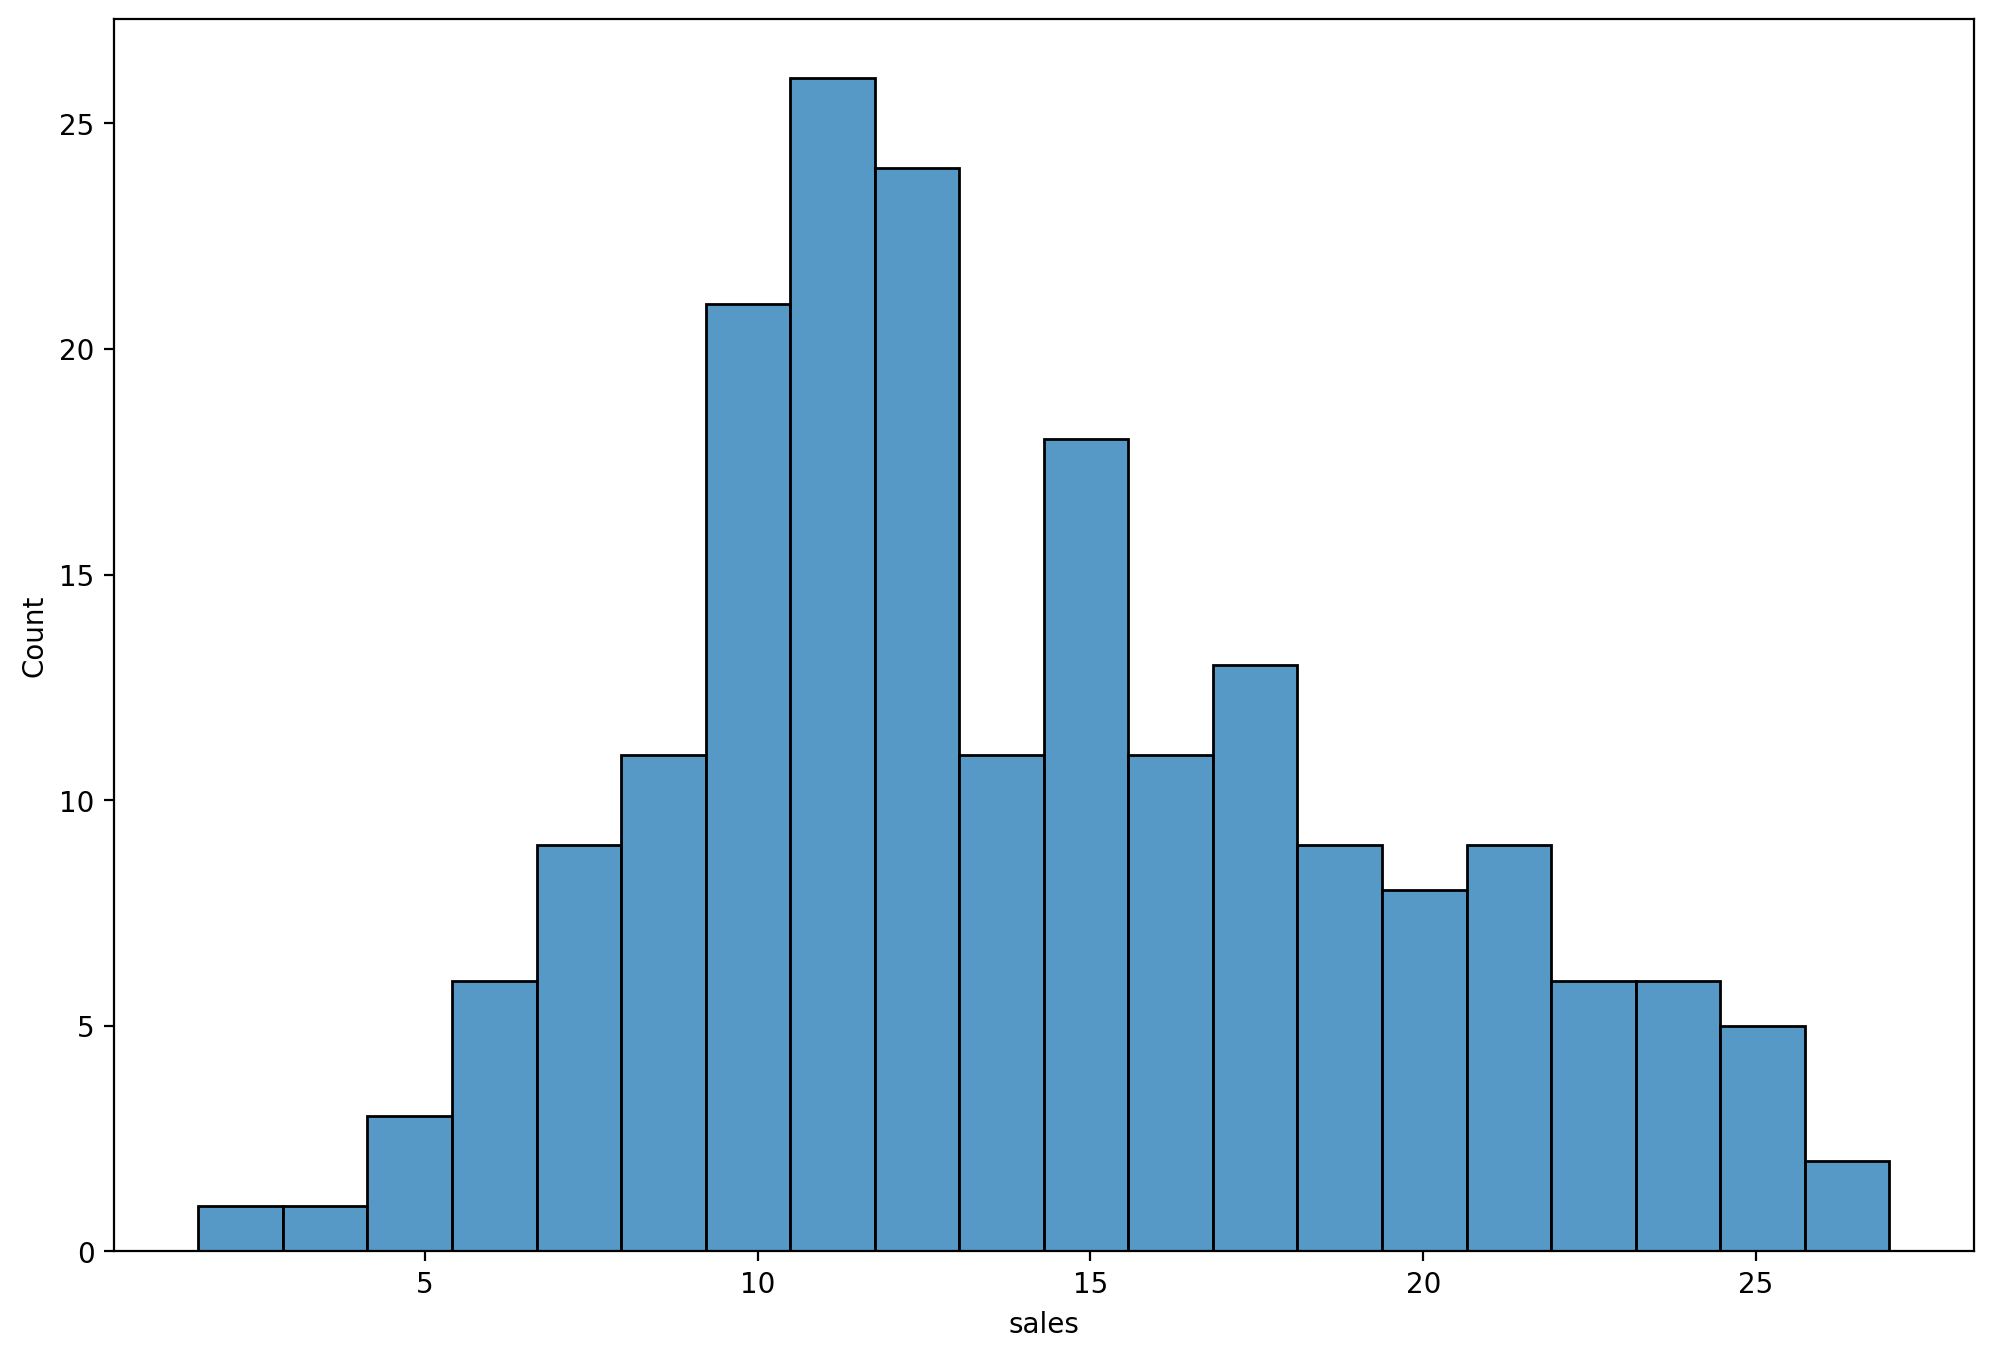

In [54]:
plt.figure(figsize=(12, 8), dpi=200)
sns.histplot(data=df, x='sales', bins=20)
plt.show()

In [56]:
MAE = mean_absolute_error(y_test, test_predictions)
MAE

1.5116692224549084

В нашем примере среднее значение равно 14, а основные значения меняются в районе от 5 до 25. 

Сравниваем 1.51 и 14:  
Процент = ((MAE / Среднее значени})) × 100

Подставим полученные значения:  
Процент = ((1.51 / 14)) × 100 ≈ 10.79%

Таким образом, MAE (1.51) составляет примерно 10.79% от среднего значения (14). 

In [58]:
MSE = mean_squared_error(y_test,test_predictions)
MSE

3.79679723671522

In [60]:
RMSE = np.sqrt(MSE)
RMSE

1.9485372043446387

Если средняя абсолютная ошибка модели ведёт себя хорошо, но при этом среднеквадратическая ошибка очень большая - это означет что модель работает хорошо для большинства точек, но для некоторых точек модель сильно ошибается.

---
---

## Анализ остатков(residuals)
Для линейной регрессии имеет смысл смотреть не только на метрику RMSE, но и на остатки(residuals): $(y - \hat{y})$, так как линейная регрессия подходит далеко не для каждого набора точек.

### Квартет Энскомба:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/850px-Anscombe%27s_quartet_3.svg.png">

<table class="wikitable">
<tbody><tr>
<th>Характеристика
</th>
<th>Значение
</th></tr>
<tr>
<td><a href="https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5_%D0%B0%D1%80%D0%B8%D1%84%D0%BC%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5" title="Среднее арифметическое">Среднее значение</a> переменной <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle x}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>x</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle x}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/87f9e315fd7e2ba406057a97300593c4802b53e4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.338ex; width:1.33ex; height:1.676ex;" alt="x"/></span>
</td>
<td>9.0
</td></tr>
<tr>
<td><a href="https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D1%8F_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B9_%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D1%8B" title="Дисперсия случайной величины">Дисперсия</a> переменной <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle x}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>x</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle x}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/87f9e315fd7e2ba406057a97300593c4802b53e4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.338ex; width:1.33ex; height:1.676ex;" alt="x"/></span>
</td>
<td>10,0
</td></tr>
<tr>
<td>Среднее значение переменной <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle y}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>y</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle y}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b8a6208ec717213d4317e666f1ae872e00620a0d" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:1.155ex; height:2.009ex;" alt="y"/></span>
</td>
<td>7,5
</td></tr>
<tr>
<td>Дисперсия переменной <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle y}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>y</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle y}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b8a6208ec717213d4317e666f1ae872e00620a0d" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:1.155ex; height:2.009ex;" alt="y"/></span>
</td>
<td>3,75
</td></tr>
<tr>
<td><a href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F" title="Корреляция">Корреляция</a> между переменными <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle x}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>x</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle x}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/87f9e315fd7e2ba406057a97300593c4802b53e4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.338ex; width:1.33ex; height:1.676ex;" alt="x"/></span> и <span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle y}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>y</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle y}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b8a6208ec717213d4317e666f1ae872e00620a0d" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:1.155ex; height:2.009ex;" alt="y"/></span>
</td>
<td>0,816
</td></tr>
<tr>
<td>Прямая <a href="https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F" title="Линейная регрессия">линейной регрессии</a>
</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle y=3+0{,}5x}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>y</mi>
        <mo>=</mo>
        <mn>3</mn>
        <mo>+</mo>
        <mn>0</mn>
        <mrow class="MJX-TeXAtom-ORD">
          <mo>,</mo>
        </mrow>
        <mn>5</mn>
        <mi>x</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle y=3+0{,}5x}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/511710bacf47835df1edb292efccc405cd56e85a" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:12.558ex; height:2.509ex;" alt="{\displaystyle y=3+0{,}5x}"/></span>
</td></tr>
<tr>
<td><a href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8" title="Коэффициент детерминации">Коэффициент детерминации</a> линейной регрессии
</td>
<td>0,67
</td></tr></tbody></table>

Все четыре набора точек имеют одинаковое среднее значение и одинаковое среднеквадратическое отклонение. Если проводить оптимальную линию регрессии с помощью МНК, то для каждого из этих наборов точек получится одна и та же линия регресии, она будет задаваться формулой $y = 3.00 +0.500x$. С точки зрения математики - метрики одинаковы для всех наборов точек. Однако, линейная регрессия подходит только для первого набора точек, для остальных наборов видно - что это либо кривая линия вместо прямой, либо почти все точки лежат на линии, но какая-то из точек находится очень далеко от общей линии.

**Вопрос: как можно численно понять, что точки не описываются линейной регрессией?** В случае многих переменных можно построить график остатков.

### Рассмотрим первый график из квартета Энскомба

In [62]:
quartet = pd.read_csv('anscombes_quartet1.csv')

In [64]:
quartet.head()

,x,y
0,10.0,8.04
1,8.0,6.95
2,13.0,7.58
3,9.0,8.81
4,11.0,8.33


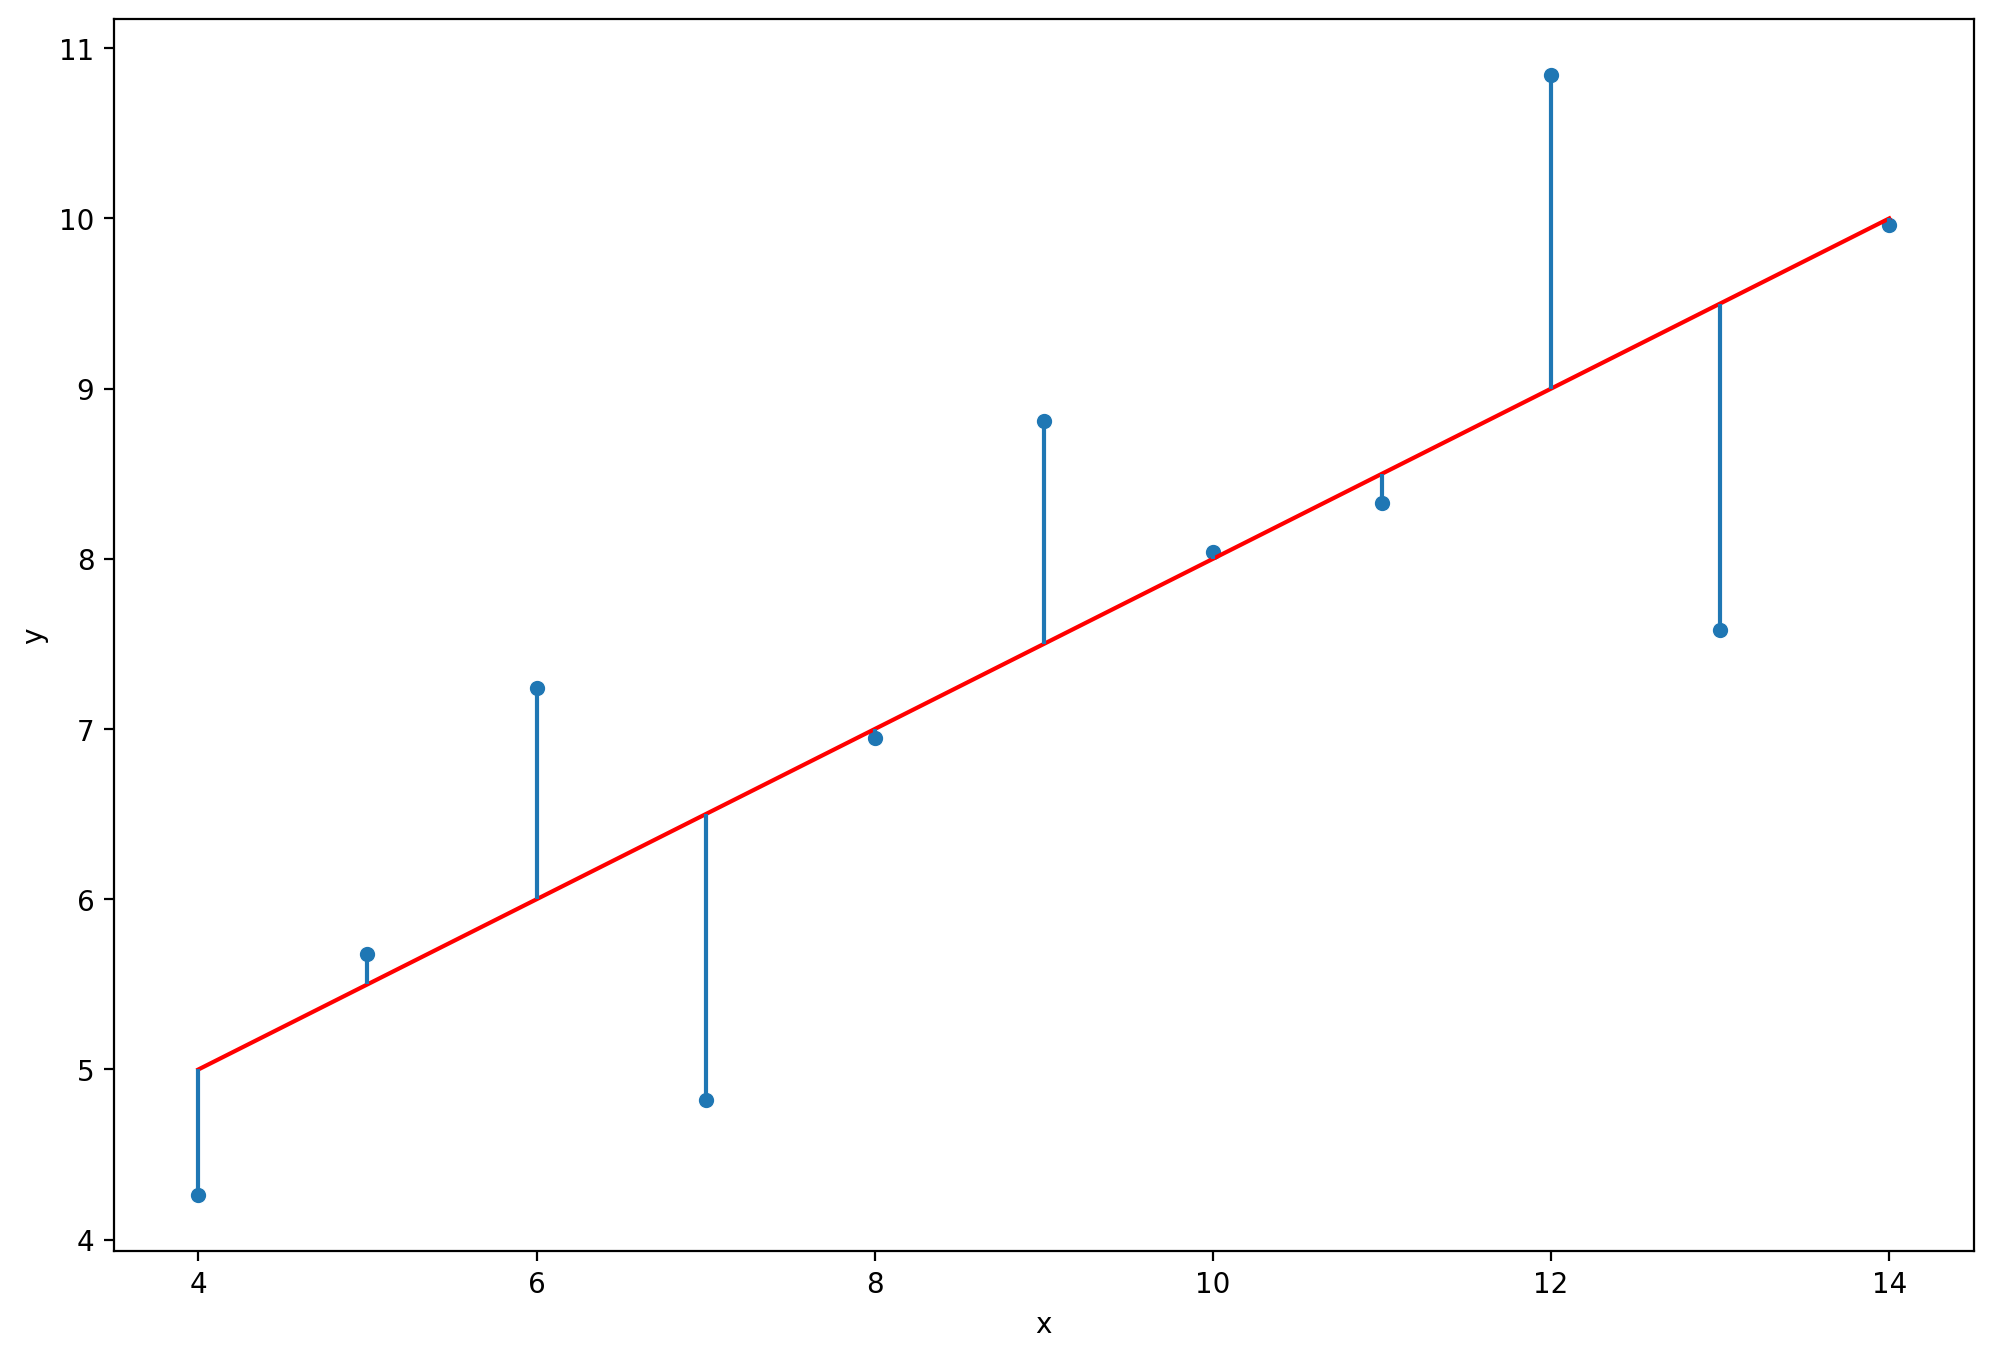

In [66]:
quartet['pred_y'] = 3 + 0.5 * quartet['x']
quartet['residual'] = quartet['y'] - quartet['pred_y']

plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='x', y='y')
sns.lineplot(data=quartet, x='x', y='pred_y', color='red')
plt.vlines(quartet['x'], quartet['y'], quartet['y']-quartet['residual'])
plt.show()

На построенном графике остатков, ошибки должны выглядеть случайным образом и быть близки к нормальному распределению. На графике изображена линия регрессии, а также сами остатки - расстояние от точек до линии. Далее можно исследовать распределение этих остатков.

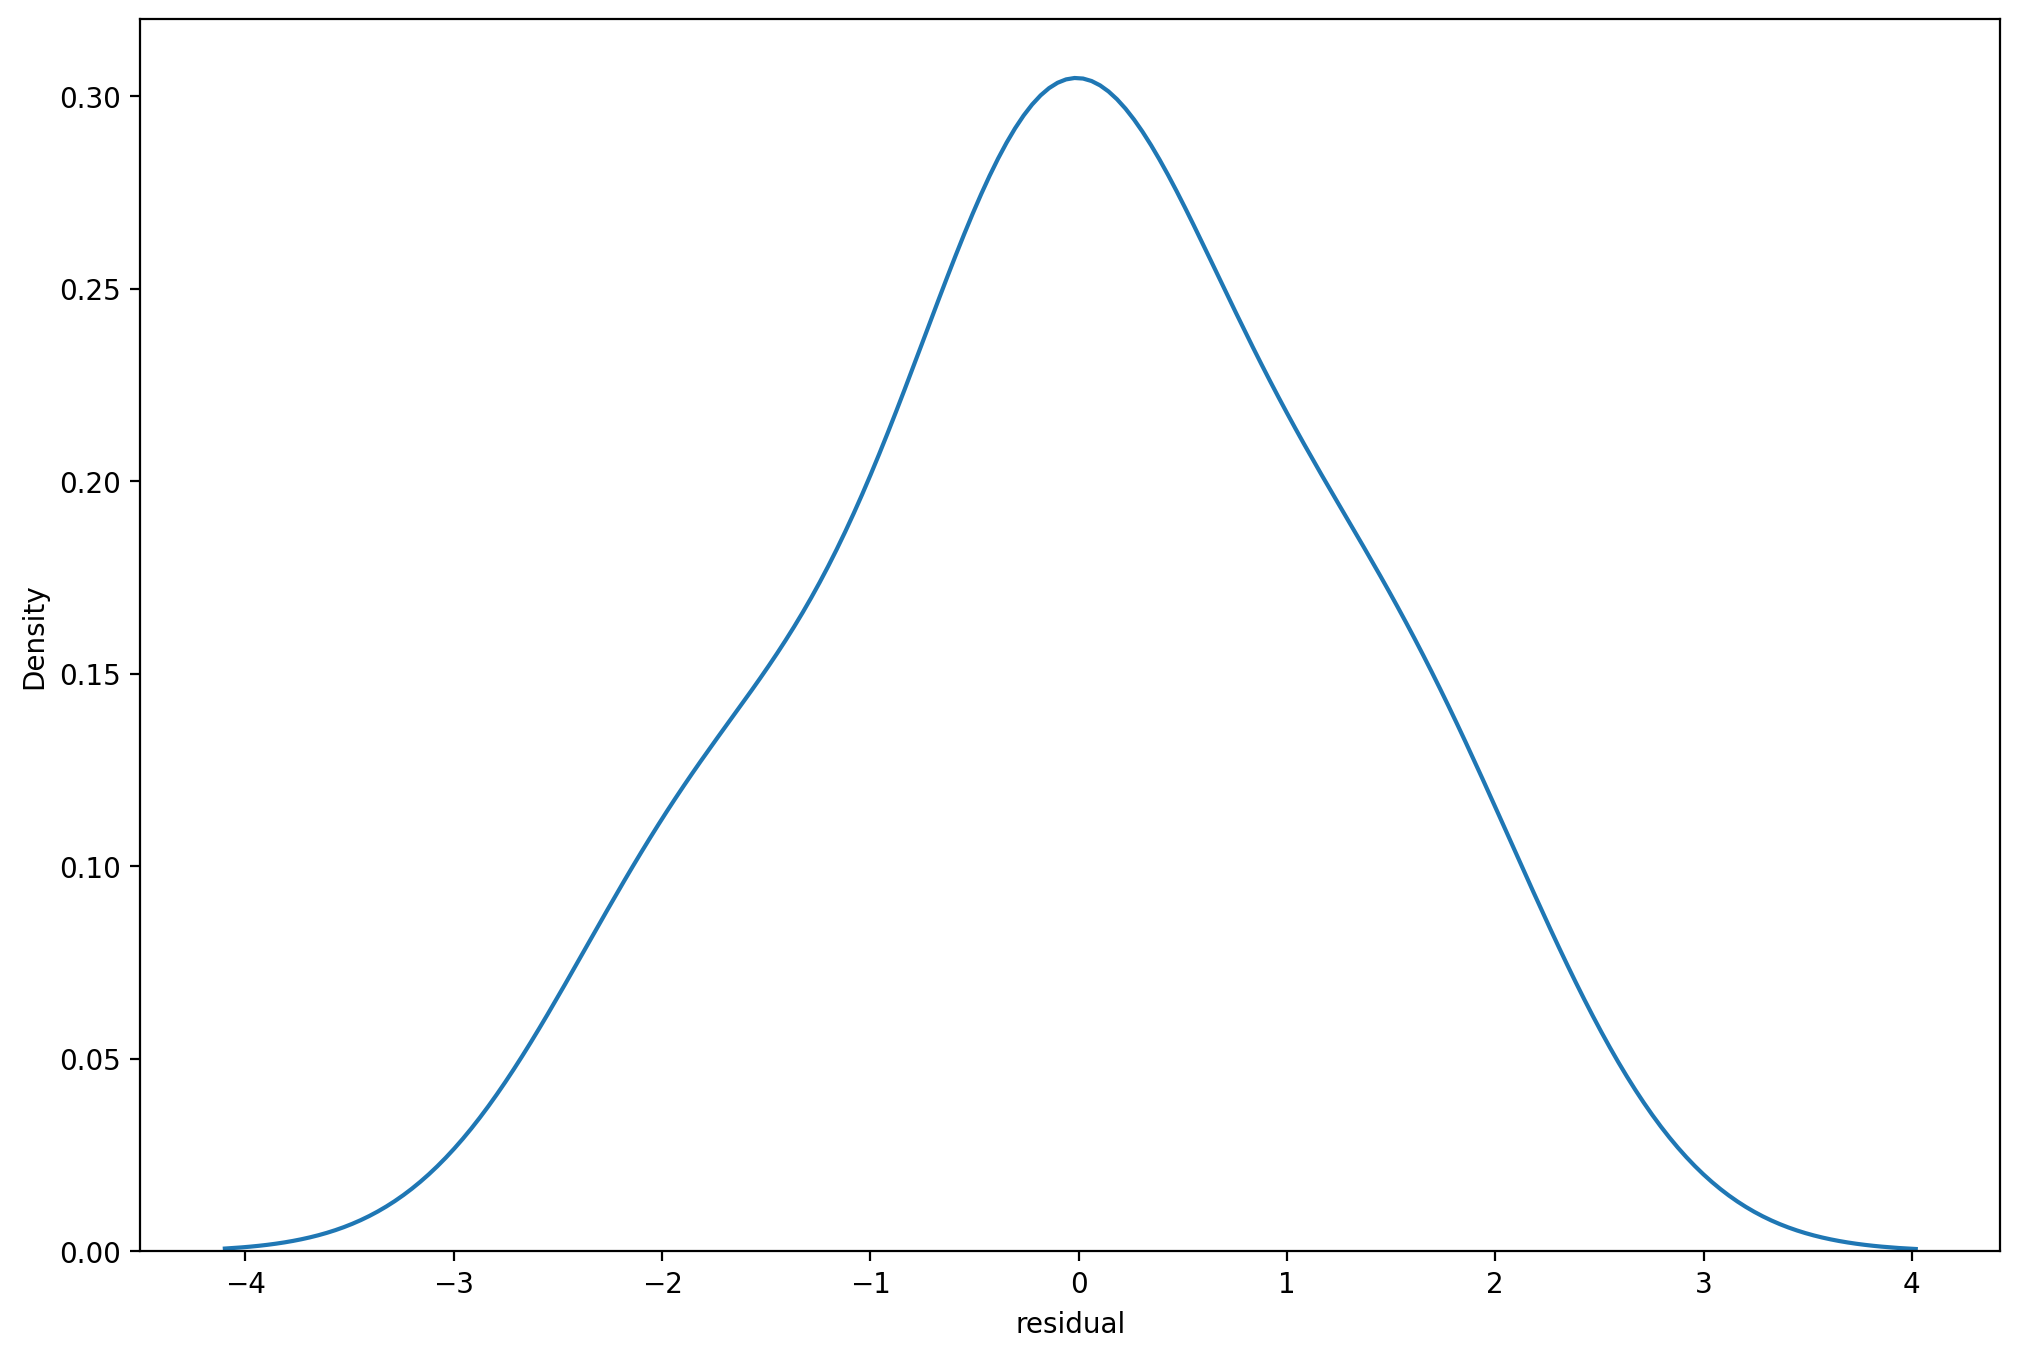

In [68]:
plt.figure(figsize=(12, 8), dpi=200)
sns.kdeplot(quartet['residual'])
plt.show()

Мы должны получить нечто похожее на нормальное распределение. В идеальном случае(когда все точки ложатся на одну линию) - остатки будут практически нулевыми. Так что можно надеяться, что распределение остатков имеет среднее значение равное нулю, так как ноль - это идельный случай. Отклонения в отрицательную или положительную сторону являются допустимыми, но в среднем - это должно происходить вокруг нуля. 

Также, кроме распределения можно построить следующий график - нанести на график остатки, а также истинные значения *y*.

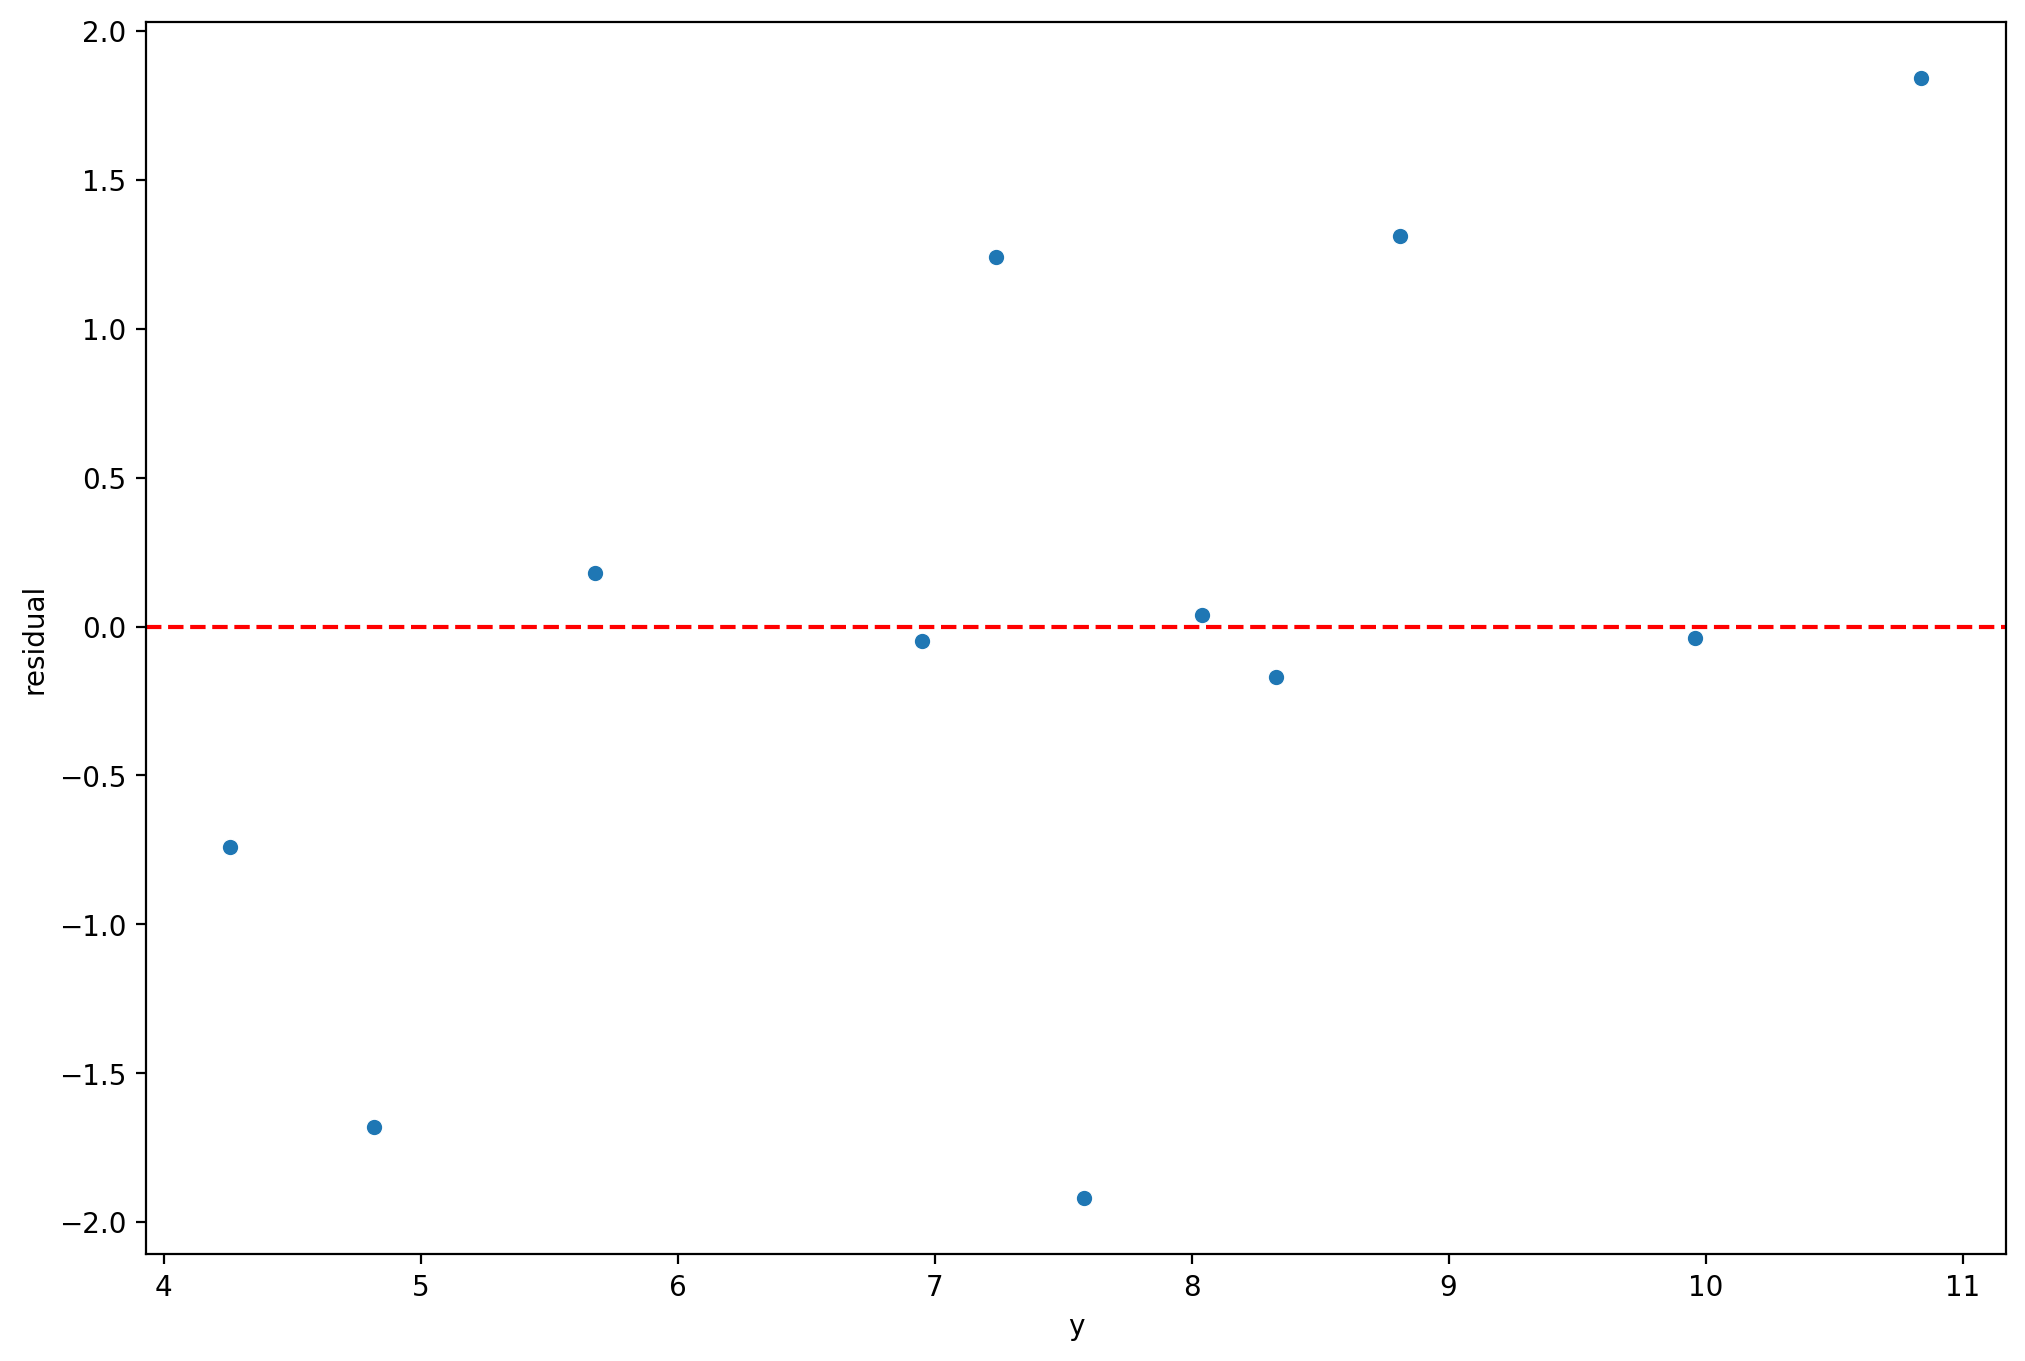

In [70]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='y', y='residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

На этом графике по вертикали нанесены остатки и с помощью пунктирной линии обозначен ноль. Если бы у нас был идеальный случай, когда на исходном графике все точки ложатся на одну прямую, то на этом графике все остатки(обозначенные синим цветом) находились бы на пунктирной линии. В реальности, мы отклоняемся от идеального случая. На этом графике мы должны увидеть более менее случайную картину, т.е. эти остатки должны выглядеть случайно. Они не должны располагаться на какой-то конкретной линии или какой-то кривой. Также, примерно половина этих остатков должна быть выше пунктирной линии, а вторая половина - ниже. 

**Важно: на этом графике изображаются только остатки и целевая переменная, без каких-либо признаков.** Поэтому, такой график можно изобразить и для случая многих признаков.

### Рассмотрим второй график из квартета Энскомба

In [72]:
quartet = pd.read_csv('anscombes_quartet2.csv')

In [74]:
quartet.columns = ['x', 'y']
quartet.head()

,x,y
0,10.0,9.14
1,8.0,8.14
2,13.0,8.74
3,9.0,8.77
4,11.0,9.26


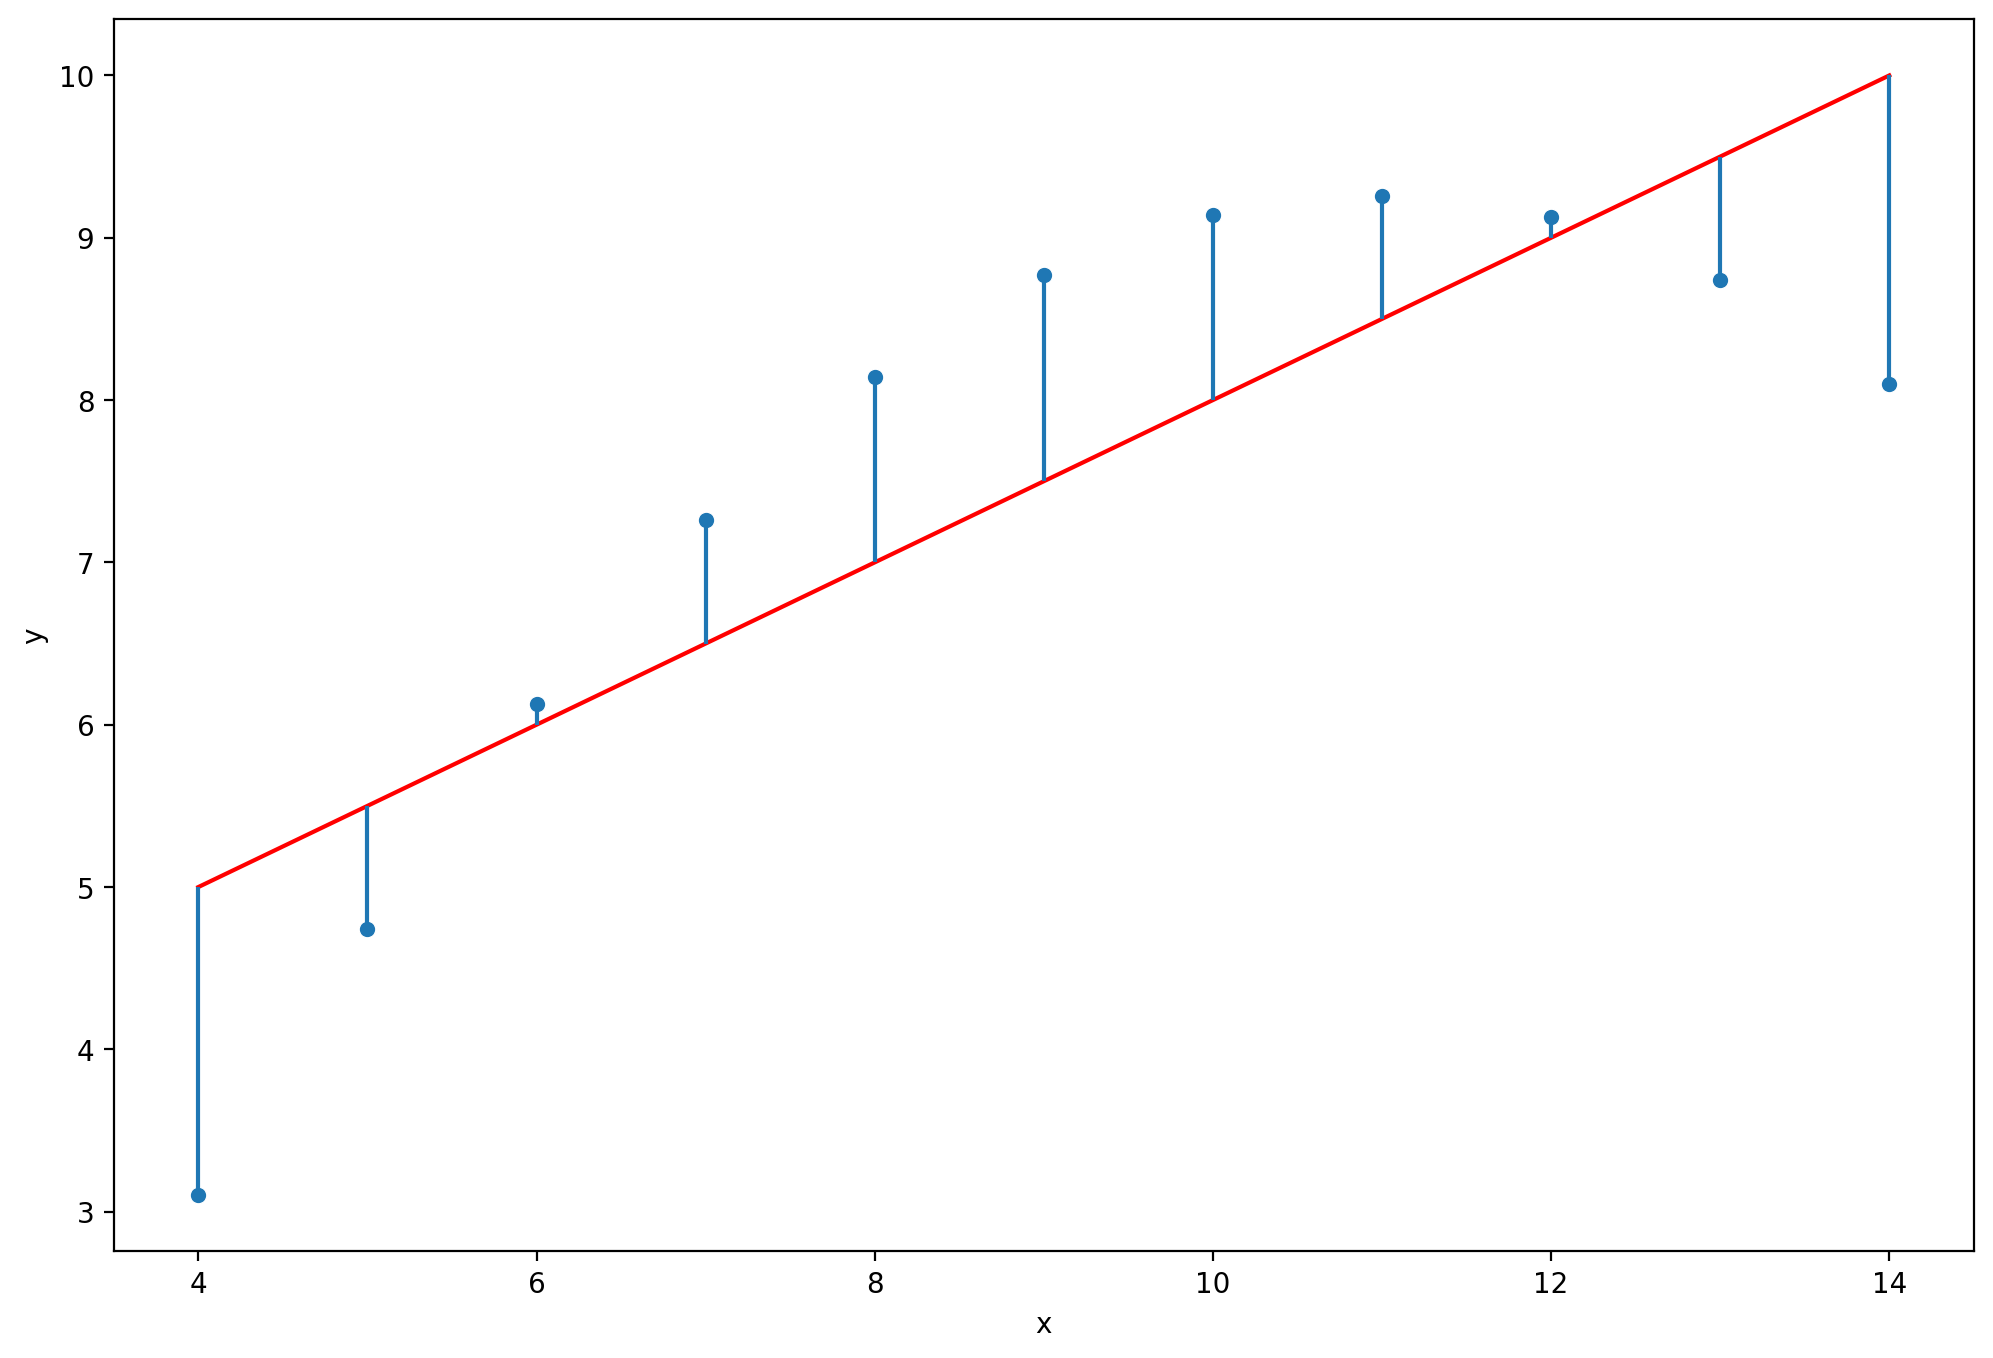

In [76]:
quartet['pred_y'] = 3 + 0.5 * quartet['x']
quartet['residual'] = quartet['y'] - quartet['pred_y']

plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='x', y='y')
sns.lineplot(data=quartet, x='x', y='pred_y', color='red')
plt.vlines(quartet['x'], quartet['y'], quartet['y']-quartet['residual'])
plt.show()

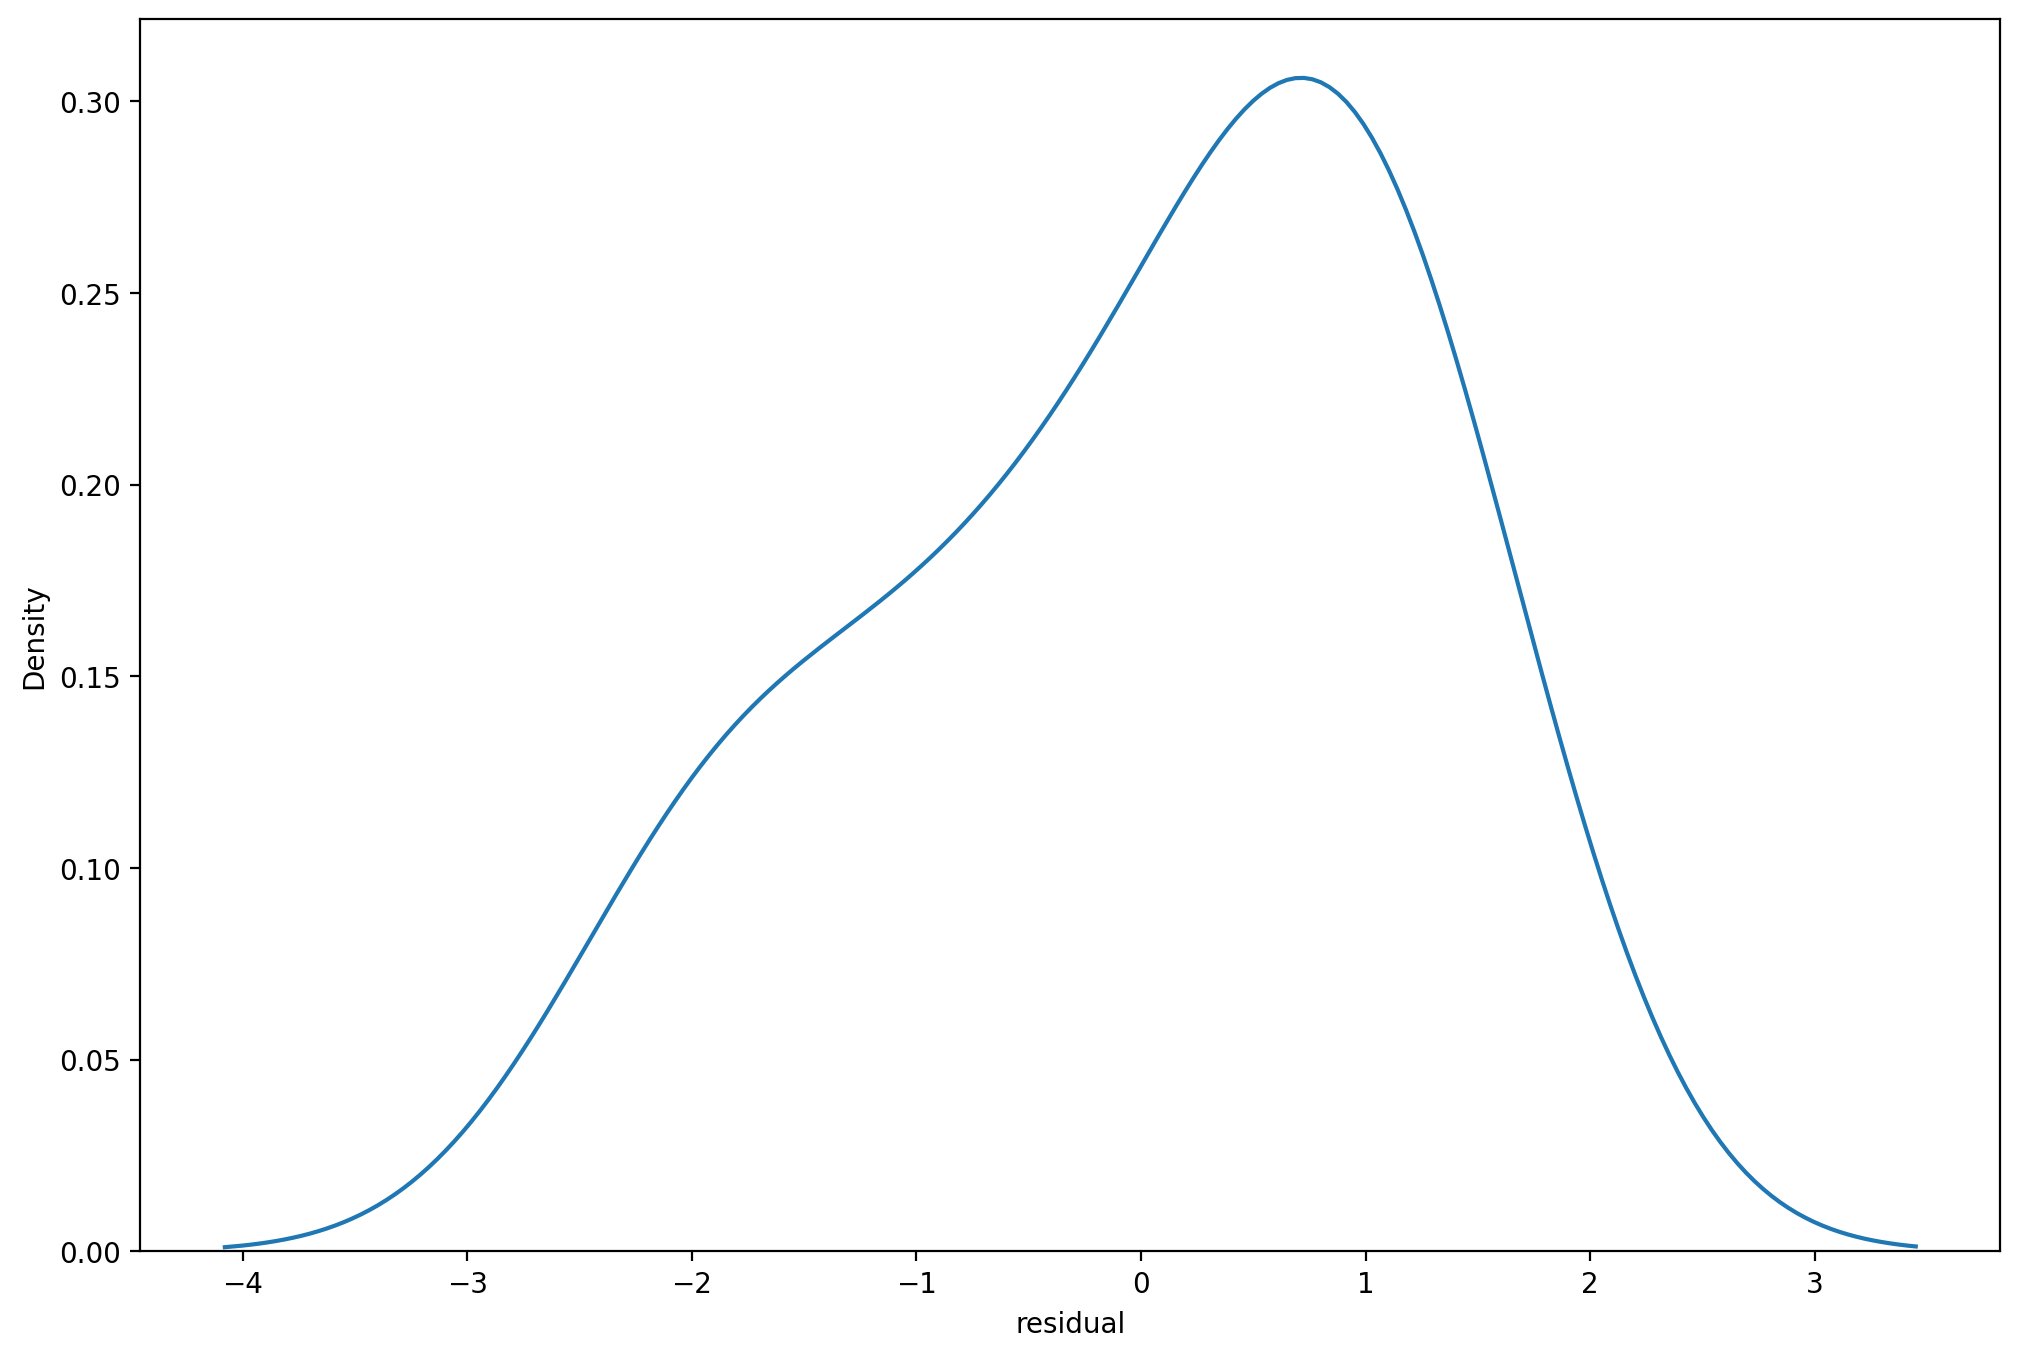

In [78]:
plt.figure(figsize=(12, 8), dpi=200)
sns.kdeplot(quartet['residual'])
plt.show()

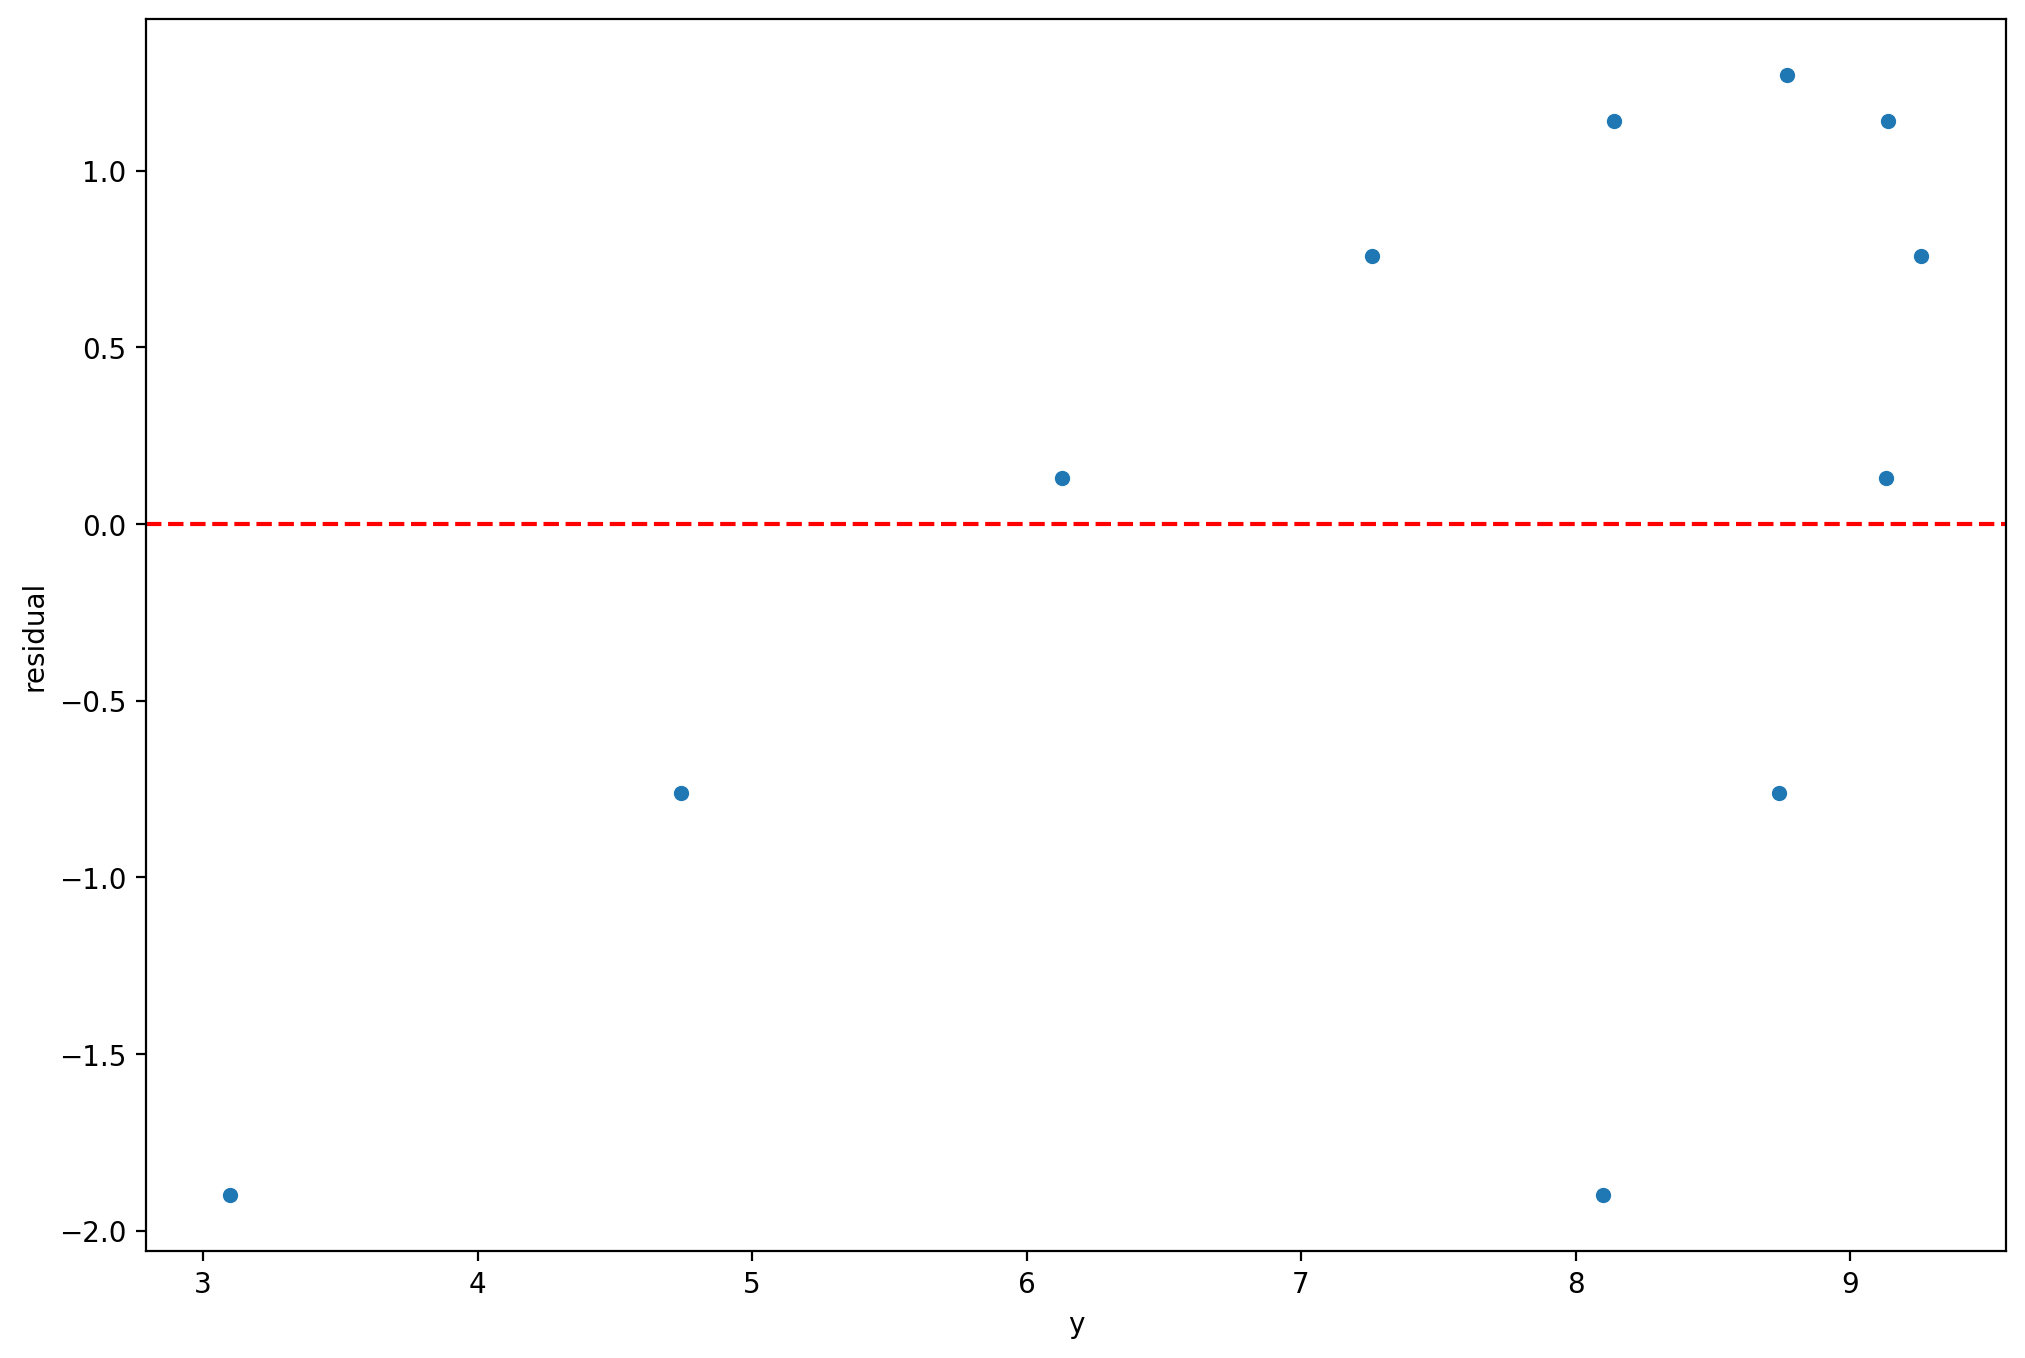

In [80]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='y', y='residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

На первом графике - мы видим сами остатки относительно линии регресии; на втором - видим некоторую несимметричность распределения, но в принципе оно приемлемо - среднее значение на нем около нуля; а вот на третьем графике - остатки не выглядят случайным образом, они находятся на некоторой кривой.

Мы можем говорить о том, что имеет место некоторая неслучайная картина => линейная регрессия не применима!

### Рассмотрим четвертый график из квартета Энскомба
В данных для этого графика x принимает всего два значения - либо 8, либо 19, поэтому попытка построить прямую линию через все точки приводит к тому, что из-за одной далеко отстоящей точки общая линия не может пройти через все эти точки.

In [82]:
quartet = pd.read_csv('anscombes_quartet4.csv')

In [84]:
quartet

,x,y
0,8.0,6.58
1,8.0,5.76
2,8.0,7.71
3,8.0,8.84
4,8.0,8.47
5,8.0,7.04
6,8.0,5.25
7,19.0,12.50
8,8.0,5.56
9,8.0,7.91


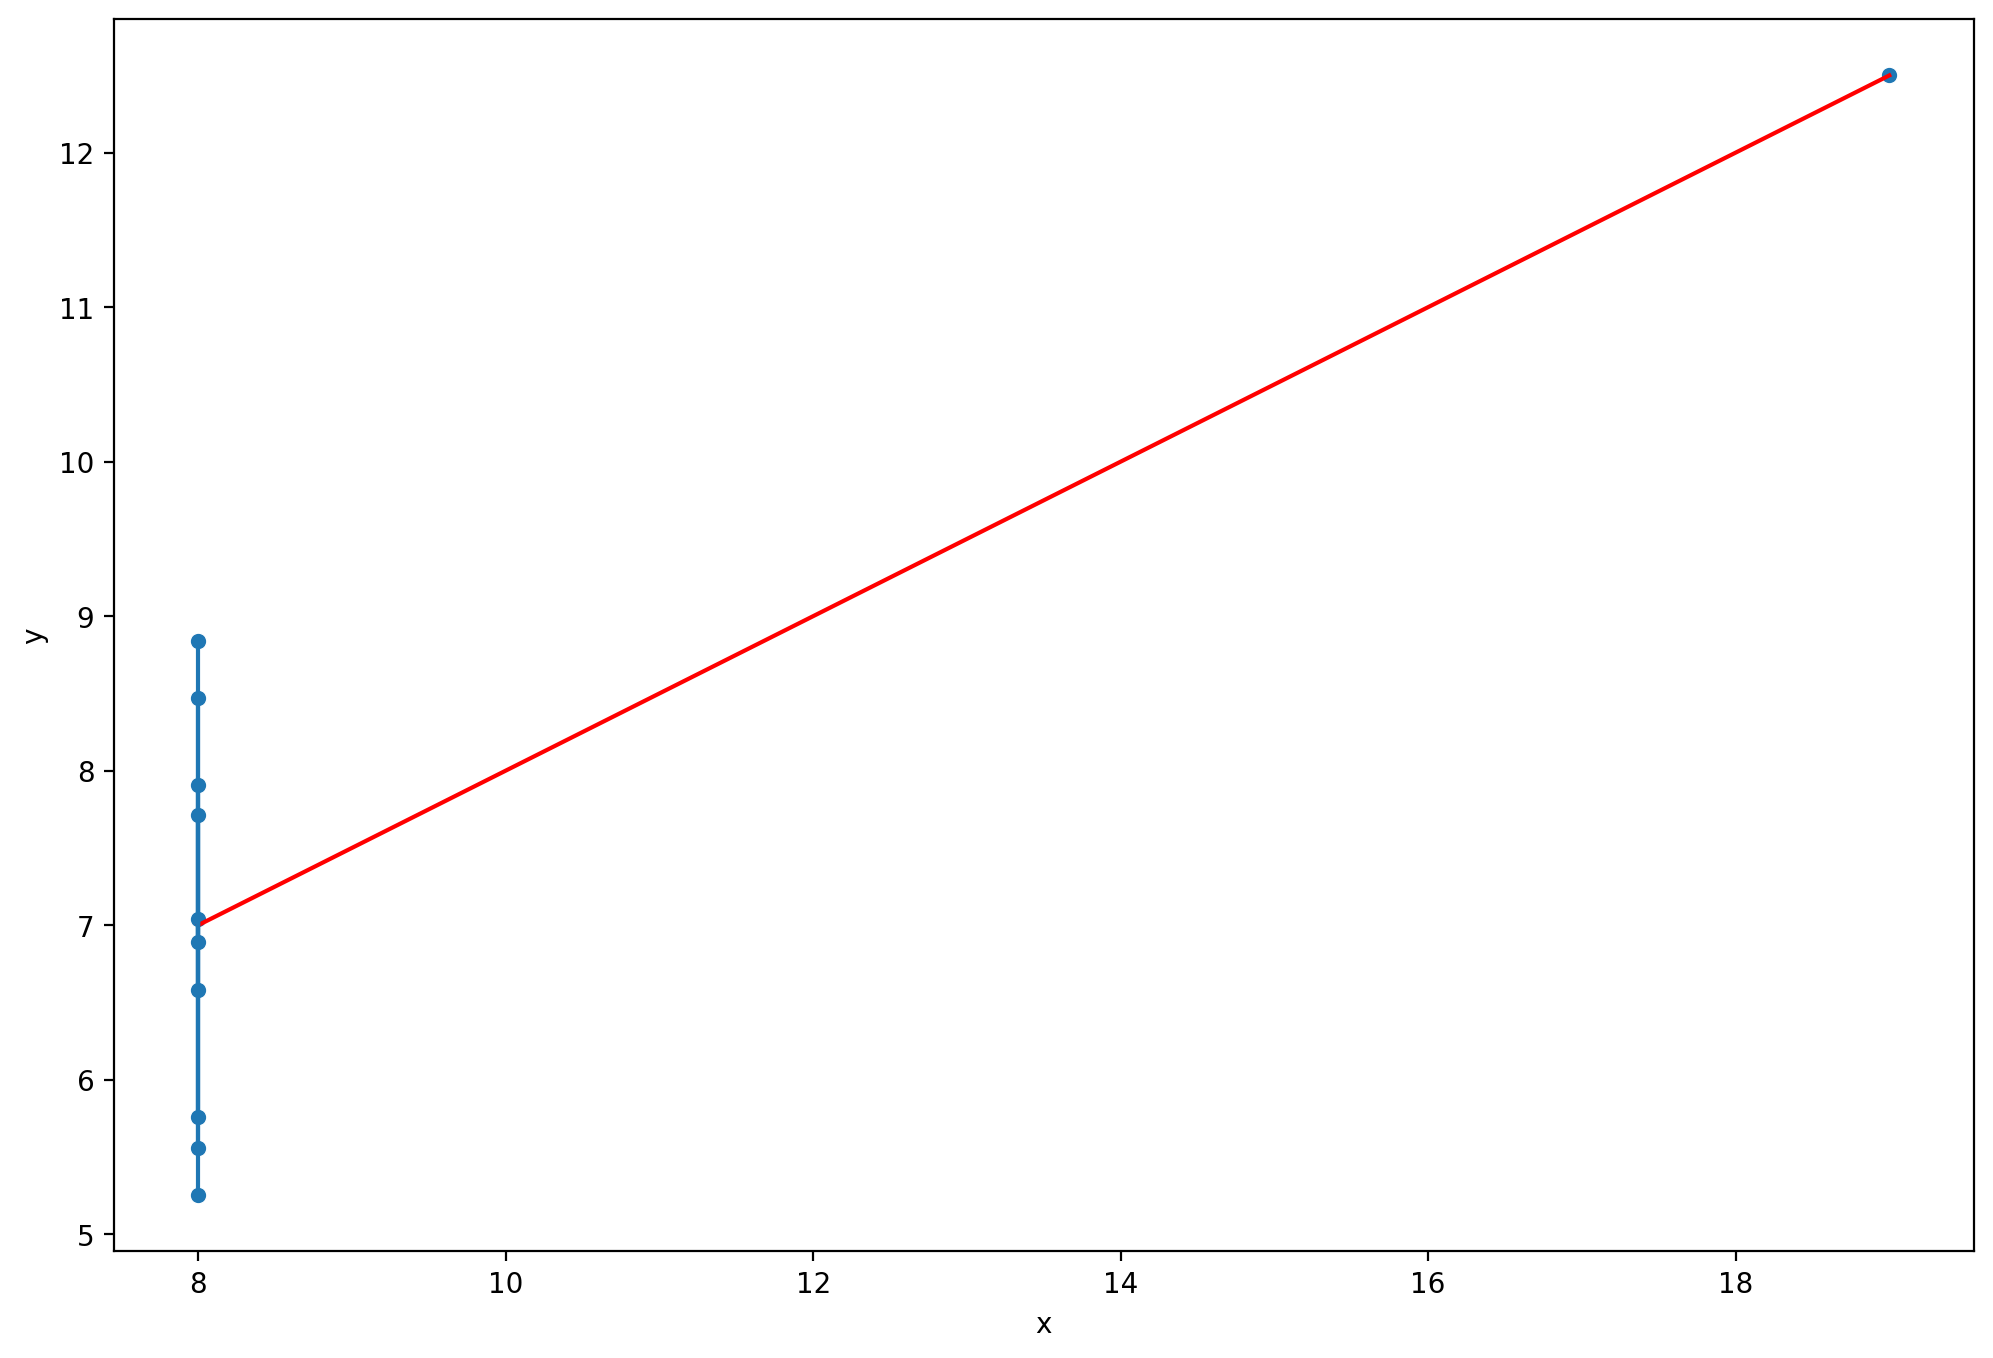

In [86]:
quartet['pred_y'] = 3 + 0.5 * quartet['x']
quartet['residual'] = quartet['y'] - quartet['pred_y']

plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='x', y='y')
sns.lineplot(data=quartet, x='x', y='pred_y', color='red')
plt.vlines(quartet['x'], quartet['y'], quartet['y']-quartet['residual'])
plt.show()

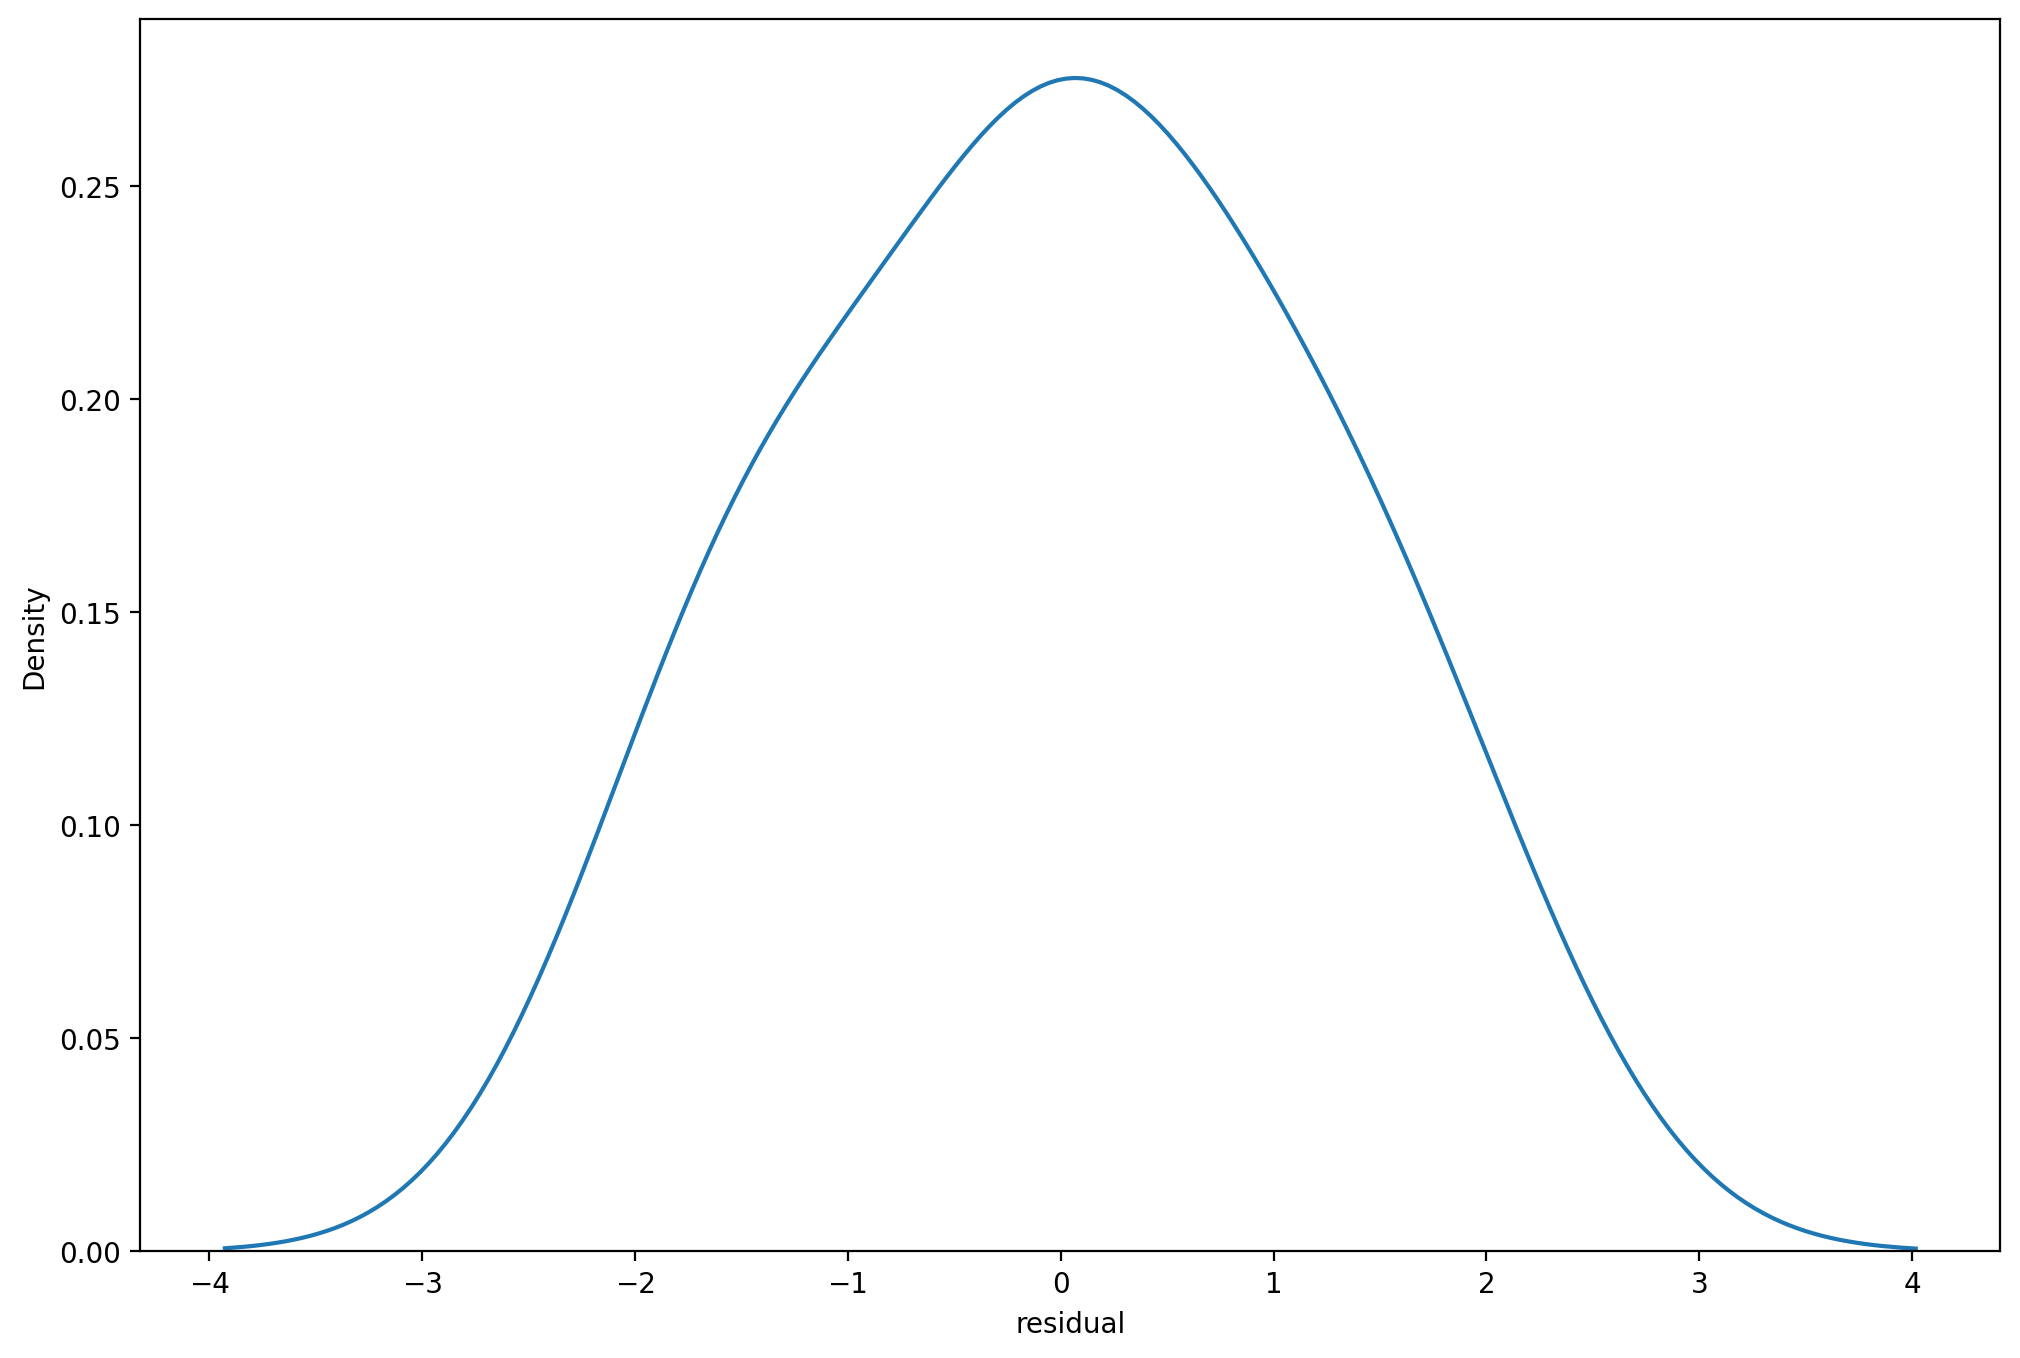

In [88]:
plt.figure(figsize=(12, 8), dpi=200)
sns.kdeplot(quartet['residual'])
plt.show()

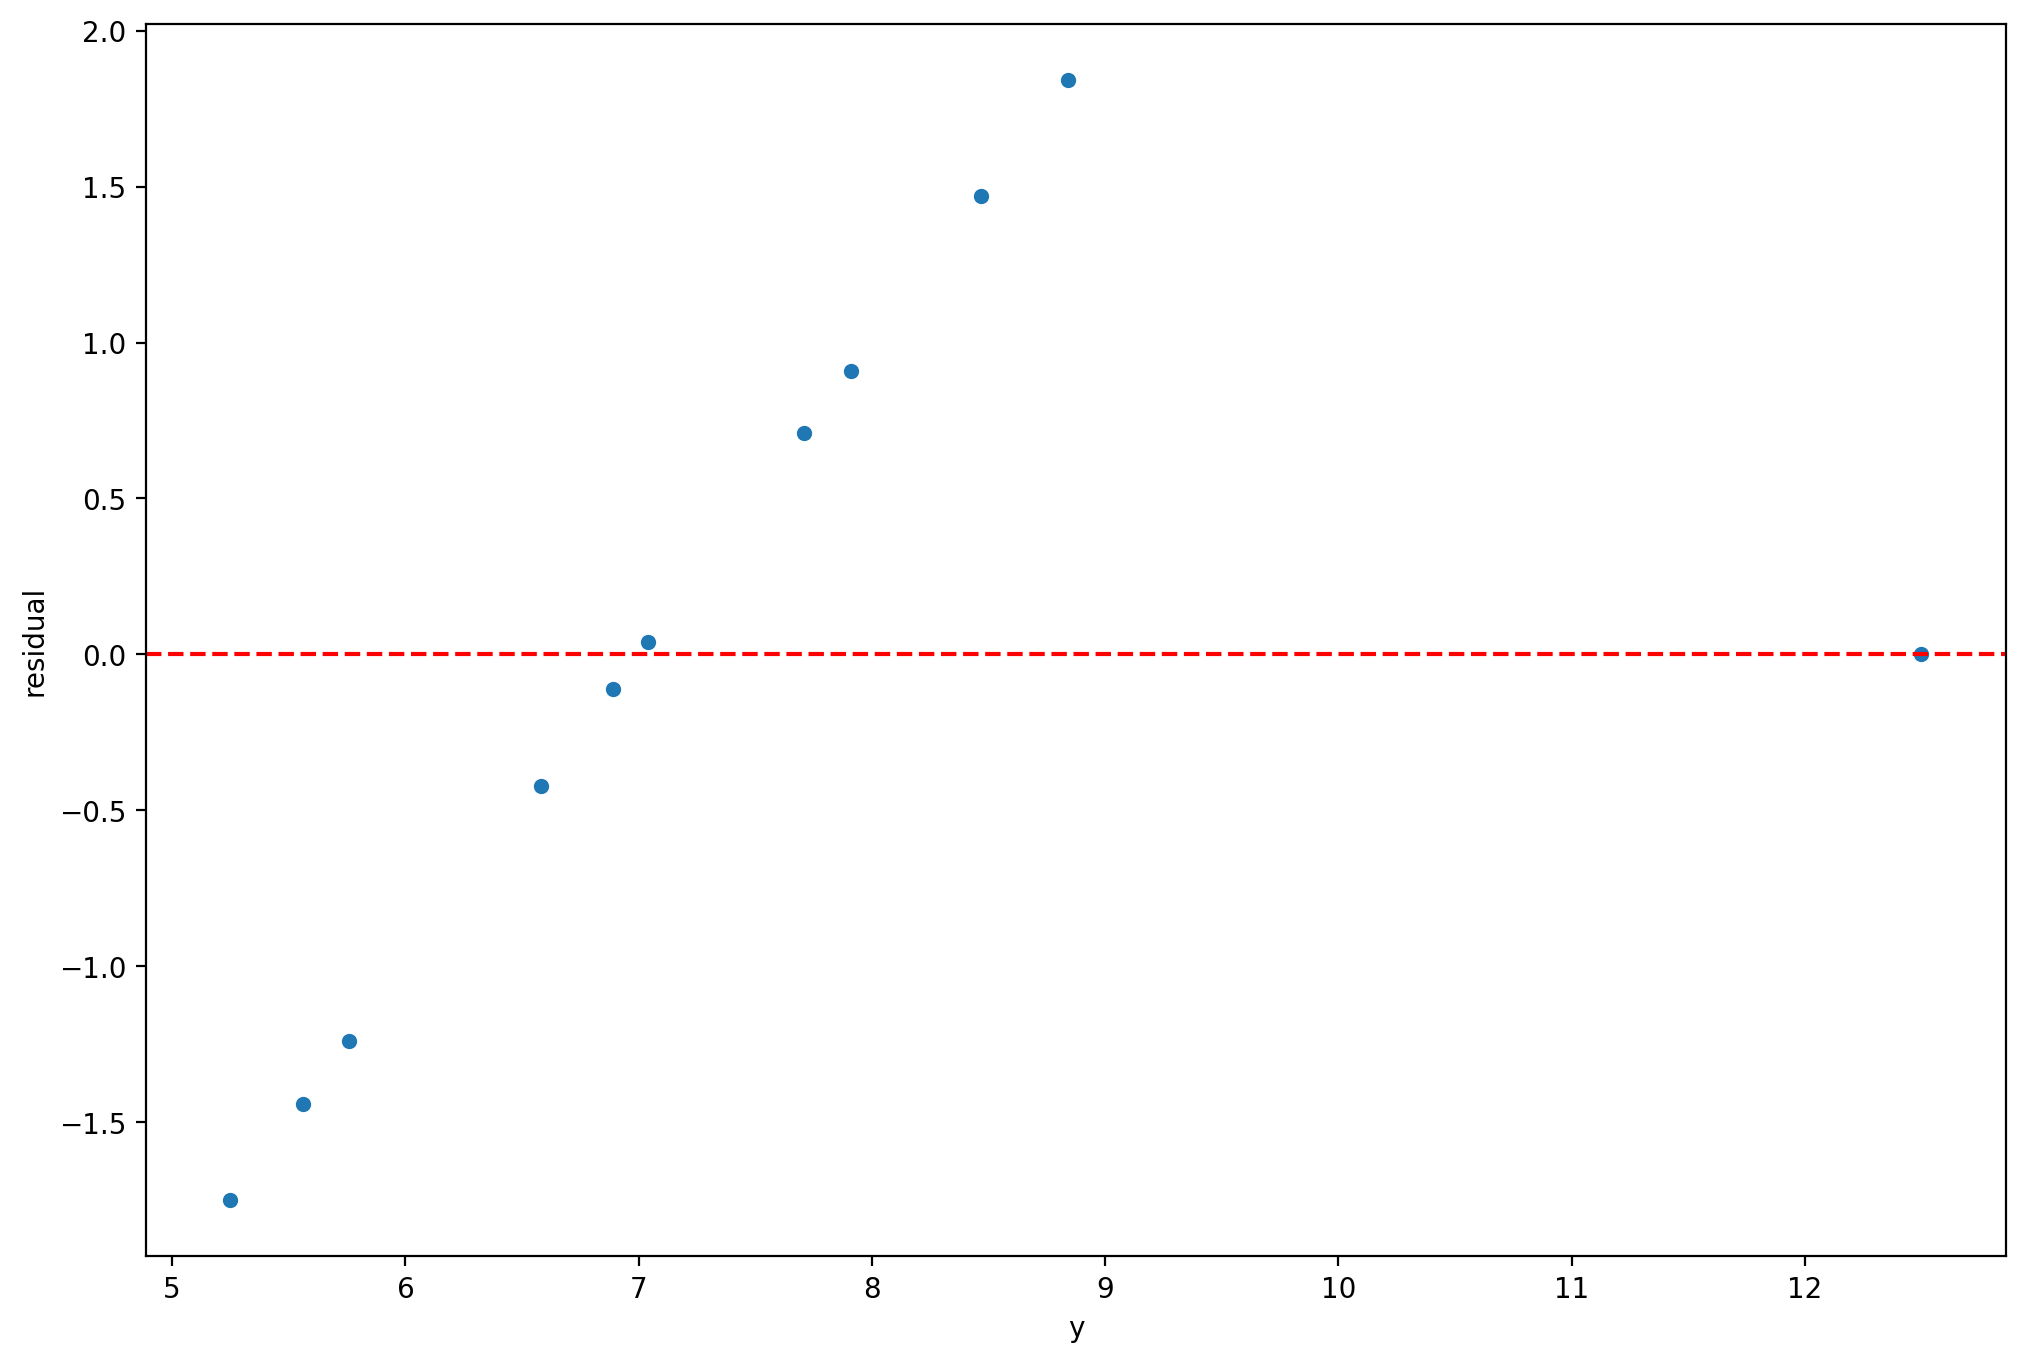

In [90]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=quartet, x='y', y='residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

На первом графике - остатки относительно линии регрессии. На втором - можно увидеть нормальное распределение со средним значением в нуле. А на третьем графике - можно увидеть, что все точки лежат на одной линии, хотя должны располагаться случайным образом.

В итоге по этому графику можно сделать вывод о том, что линейная регрессия не подходит для этого набора точек!

---
---

## Проведем похожее исследование для исходного набора данных
Работая с остатками по отдельности, можно увидеть, не было ли проблем при разбиении данных с помощью split

In [92]:
test_residuals = y_test - test_predictions

In [94]:
test_residuals

95     0.334604
15     1.211772
30    -0.151071
158   -3.589238
128    2.497680
115   -0.755569
69     1.103075
170    1.049715
174   -1.775471
45    -0.224495
66     0.485570
182    2.174572
165   -2.402060
78    -3.670260
186    0.843204
177   -0.304544
56    -3.415494
152    0.443807
82     1.004171
68     0.175264
124   -0.068218
16    -1.274690
148   -1.596389
93     0.664982
65     1.691393
60     2.488020
84     0.782405
67     1.593723
125    1.519234
132   -2.814120
9     -1.576049
18     1.330806
55     1.969910
75    -4.077706
150   -2.001136
104    0.624092
135   -2.662026
137   -0.138265
164    1.060612
76     2.518094
79     1.486676
197    0.395137
38    -0.070454
24     1.609186
122   -1.563884
195    2.375645
29     1.211062
19     0.506693
143    1.709755
86     0.338802
114   -1.118484
173    0.068431
5     -6.153607
126   -4.553147
117    3.063632
73     1.238420
140    1.480429
98     1.144835
172   -0.095191
96    -0.453176
Name: sales, dtype: float64

Если бы у нас была идеальная модель, то все эти остатки были бы равны нулю. Здесь мы можем увидеть как положительные так и отрицательные значения - насколько предсказания модели отклоняются от реальных значений.

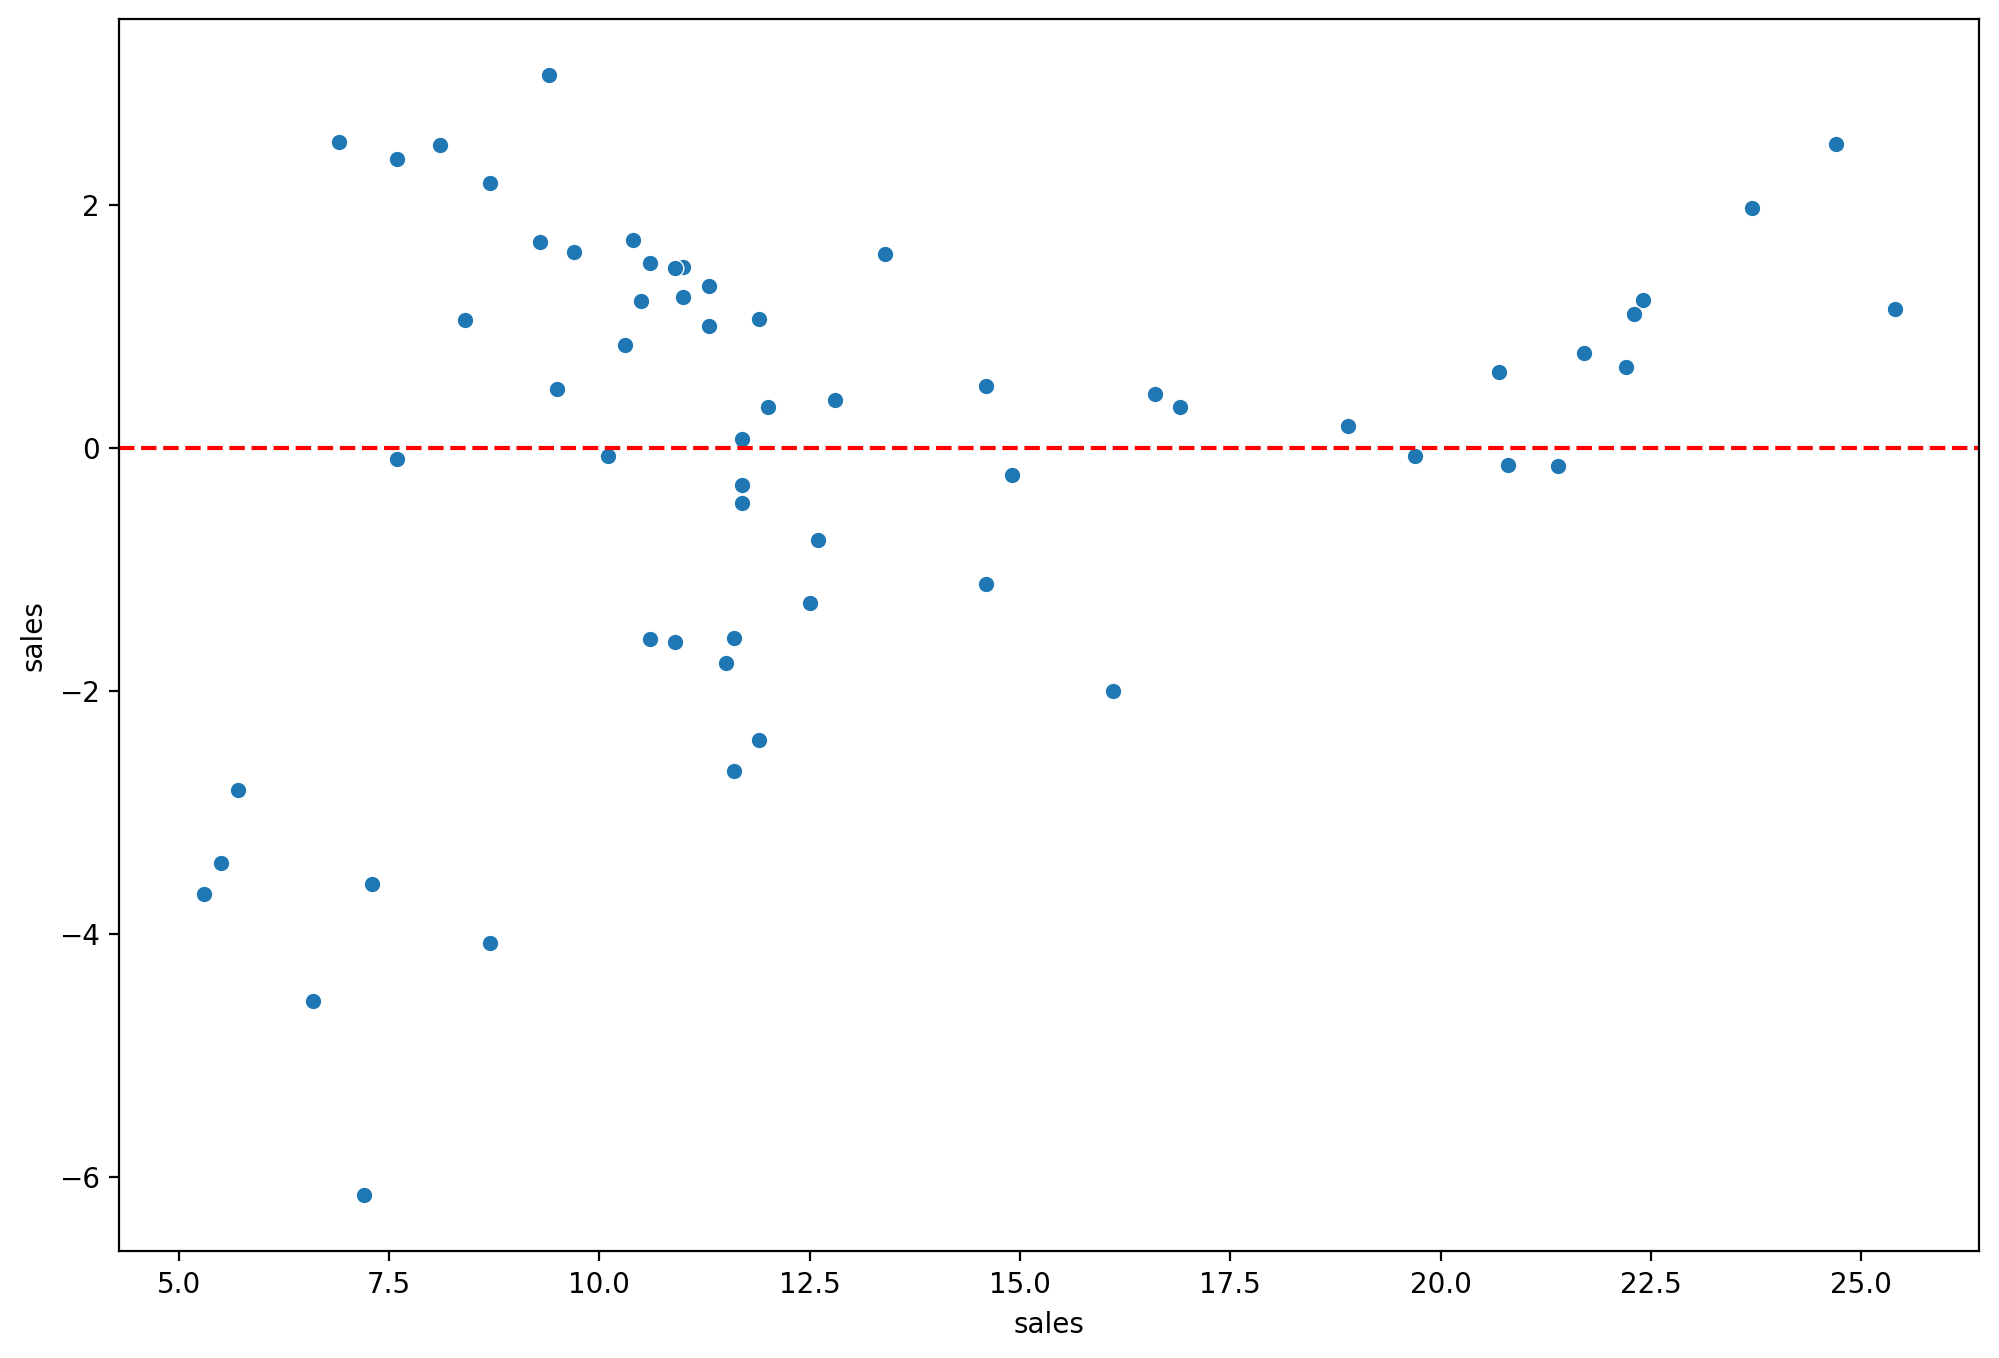

In [96]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(x=y_test, y=test_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Мы получаем картину, которая выглядит более-менее случайным образом

<Figure size 2400x1600 with 0 Axes>

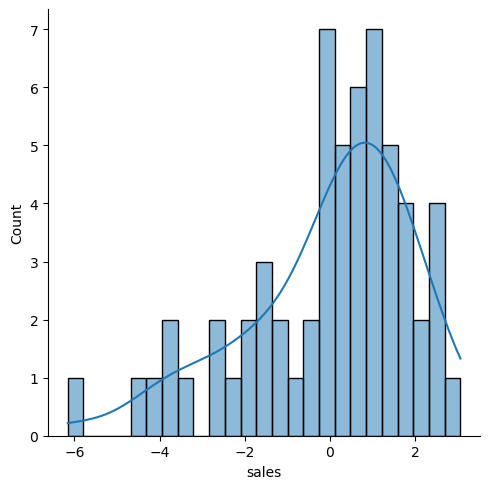

In [98]:
plt.figure(figsize=(12, 8), dpi=200)
sns.displot(data=test_residuals, bins=25, kde=True)
plt.show()

Мы видим график с центром в районе нуля, немного перекошенный в положительную сторону, но не так страшно. Главное, чтобы на предыдущем графике не было какой-либо структурированной картины, особенно какой-либо прямой или кривой линии.

Бывают случаи, когда сложно сказать - является ли распределение данных нормальным. Для таких случаев можно построить график normal probability plot. Этот график, рядом с нашими данными нарисует классическое нормальное распределение данных.

In [100]:
import scipy as sp

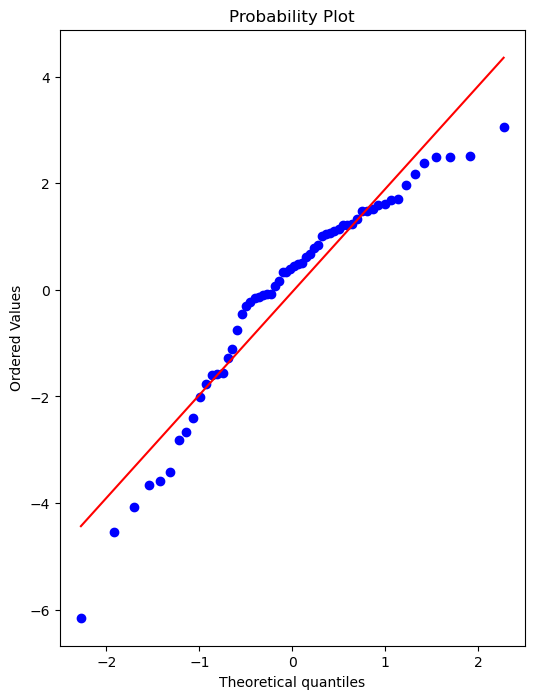

In [102]:
# Создаём объект figure и оси для рисования графика
fig, ax = plt.subplots(figsize=(6,8), dpi=100)

# probplot возвращает значения, которые можно использовать при необходимости
# мы хотим просто нарисовать график, поэтому присваиваем эти значения переменной _
_ = sp.stats.probplot(test_residuals, plot=ax)

На этом графике красная линия - это то, как должно выглядеть идеальное нормальное распределение данных.

---
---

## Повторное обучение модели на новых данных
Если результаты работы модли на тестовых данных нас устраивают, то прежде чем передавать модель в эксплуатацию, мы можем выполнить обучение модели на всех данных.(Если же результаты работы модели на тестовых данных не являются хорошими, то можно поменять значения параметров или выбрать другую модель.)

In [116]:
final_model = LinearRegression()

In [118]:
final_model.fit(X, y)

LinearRegression()

**Важно: после того, как мы обучили модель на всех данных, уже не имеет смысла заново считать метрику RMSE. Дело в том, что модель увидела все данные, и метрика RMSE уже не будет хорошей оценкой производительности модели, как это было в случае с тестовыми данными.**

---
---

## Атрибуты модели
### Коэффициенты
Посмотрим на финальные коэффициенты модели и интерпретируем их. Это будут $\beta$ коэффициенты линейной регрессии.

In [125]:
final_model.coef_

array([ 0.04576465,  0.18853002, -0.00103749])

Здесь коэффициенты указаны в том же порядке, что и признаки в наборе признаков, т.е. первый коэффициент - для TV, второй - для radio, третий - для newspaper.

In [129]:
X.head()

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4


Интерпретация коэффициентов:

---
* Когда все другие признаки зафиксированы, то увеличение на 1 "единицу" (на тысячу долларов) признака TV Spend приведёт к увеличению продаж на 0.045 "единиц продаж", в данном случае тысячи единиц. 
* По сути это означает, что на каждые $1000, потраченные на рекламу TV, мы можем ожидать продажи дополнительных 45 единиц товара.
----

---
---
* Когда все другие признаки зафиксированы, то увеличение на 1 "единицу" (на тысячу долларов) признака Radio Spend приведёт к увеличению продаж на 0.188  "единиц продаж", в данном случае тысячи единиц.
* По сути это означает, что на каждые $1000, потраченные на рекламу Radio, мы можем ожидать продажи дополнительных 188 единиц товара.
----
----

* Когда все другие признаки зафиксированы, то увеличение на 1 "единицу" (на тысячу долларов) признака Newspaper Spend приведёт к **уменьшению** продаж на 0.001 "единиц продаж", в данном случае тысячи единиц. 
* По сути это означает, что на каждые $1000, потраченные на рекламу Newspaper Ads, мы на самом деле ожидаем продать на 1 товар меньше. Поскольку эта цифра так близка к нулю, по сути это означает, что реклама в газетах практически не влияет на продажи.
---
---

**Важно! В данном примере единицы измерения одинаковы для всех признаков (1 единица измерения равна $1000 рекламного бюджета). Однако в других наборах данных, разные признаки могут иметь разные единицы измерения. Например, в наборе данных о домах - "housing" - мы будем пытаться предсказать цену продажи дома, исходя из признака "количество спален в доме" и признака "общая площадь дома". В таком случае будет полезно *нормализовать* данные для того, чтобы получить сравнимые между собой признаки и результаты.**

### Финальная модель
Мы можем нарисовать такие графики, потому что признаков всего три. Для большего количества такой подход уже не будет эффективным. Для начала получим предсказания модели для наших признаков X.

In [139]:
y_hat = final_model.predict(X)

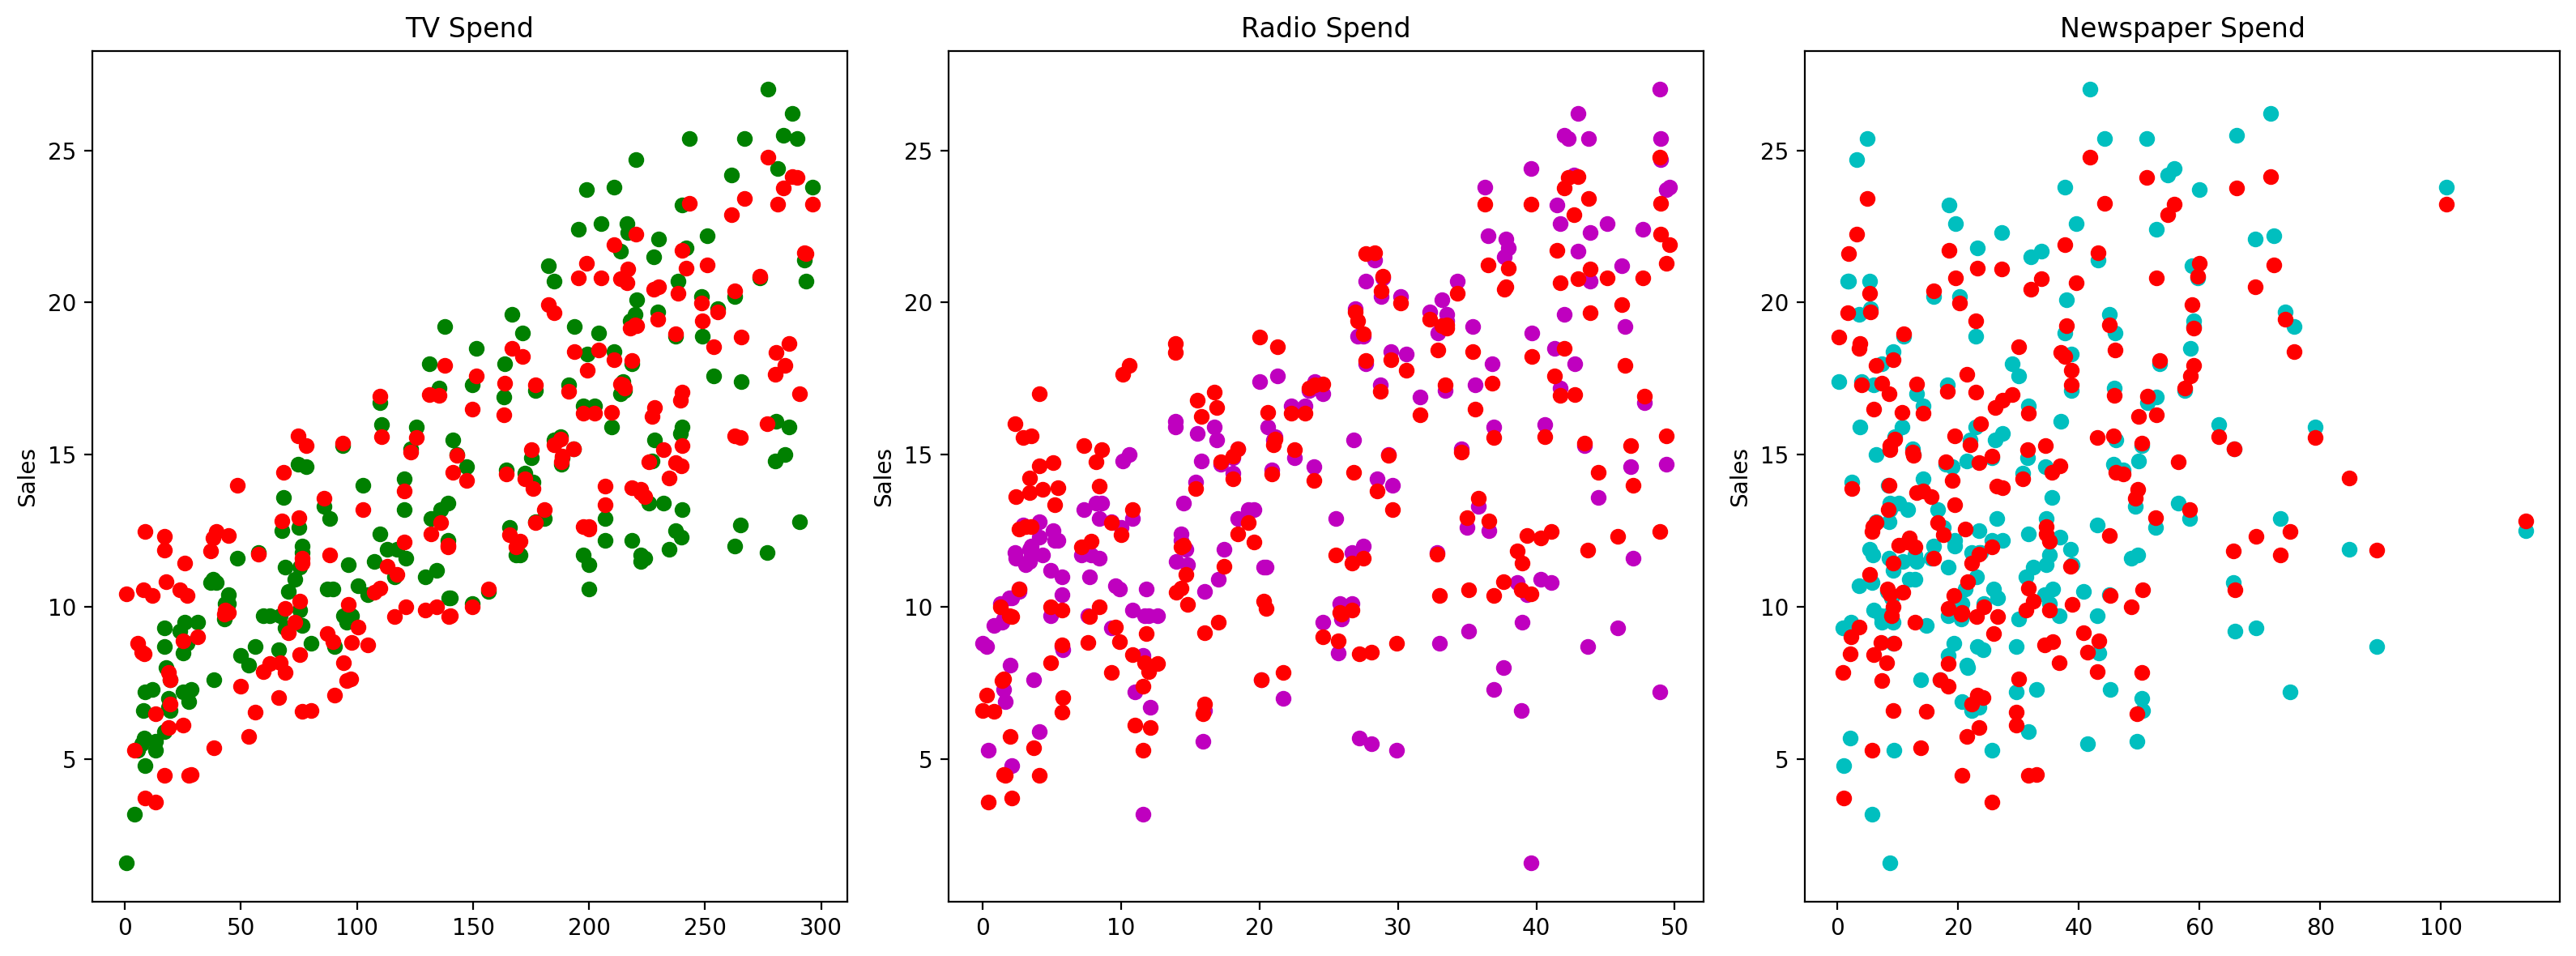

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), dpi=200)

axes[0].plot(df['TV'], df['sales'], 'go')
axes[0].plot(df['TV'], y_hat, 'o', color='red')
axes[0].set_ylabel('Sales')
axes[0].set_title('TV Spend')

axes[1].plot(df['radio'], df['sales'], 'mo')
axes[1].plot(df['radio'], y_hat, 'o', color='red')
axes[1].set_ylabel('Sales')
axes[1].set_title('Radio Spend')

axes[2].plot(df['newspaper'], df['sales'], 'co')
axes[2].plot(df['newspaper'], y_hat, 'o', color='red')
axes[2].set_ylabel('Sales')
axes[2].set_title('Newspaper Spend')

plt.tight_layout()
plt.show()

На этих графиках истинные значения целевой переменной для каждого признака изображены разными цветами, предсказания модели изображены красным цветом для каждой переменной. На этих графиках можно визуально сравнить насколько предсказания модели визуально близки или далеки от истинных значений целевой переменной.

### Остатки

In [146]:
residuals = y_hat - y

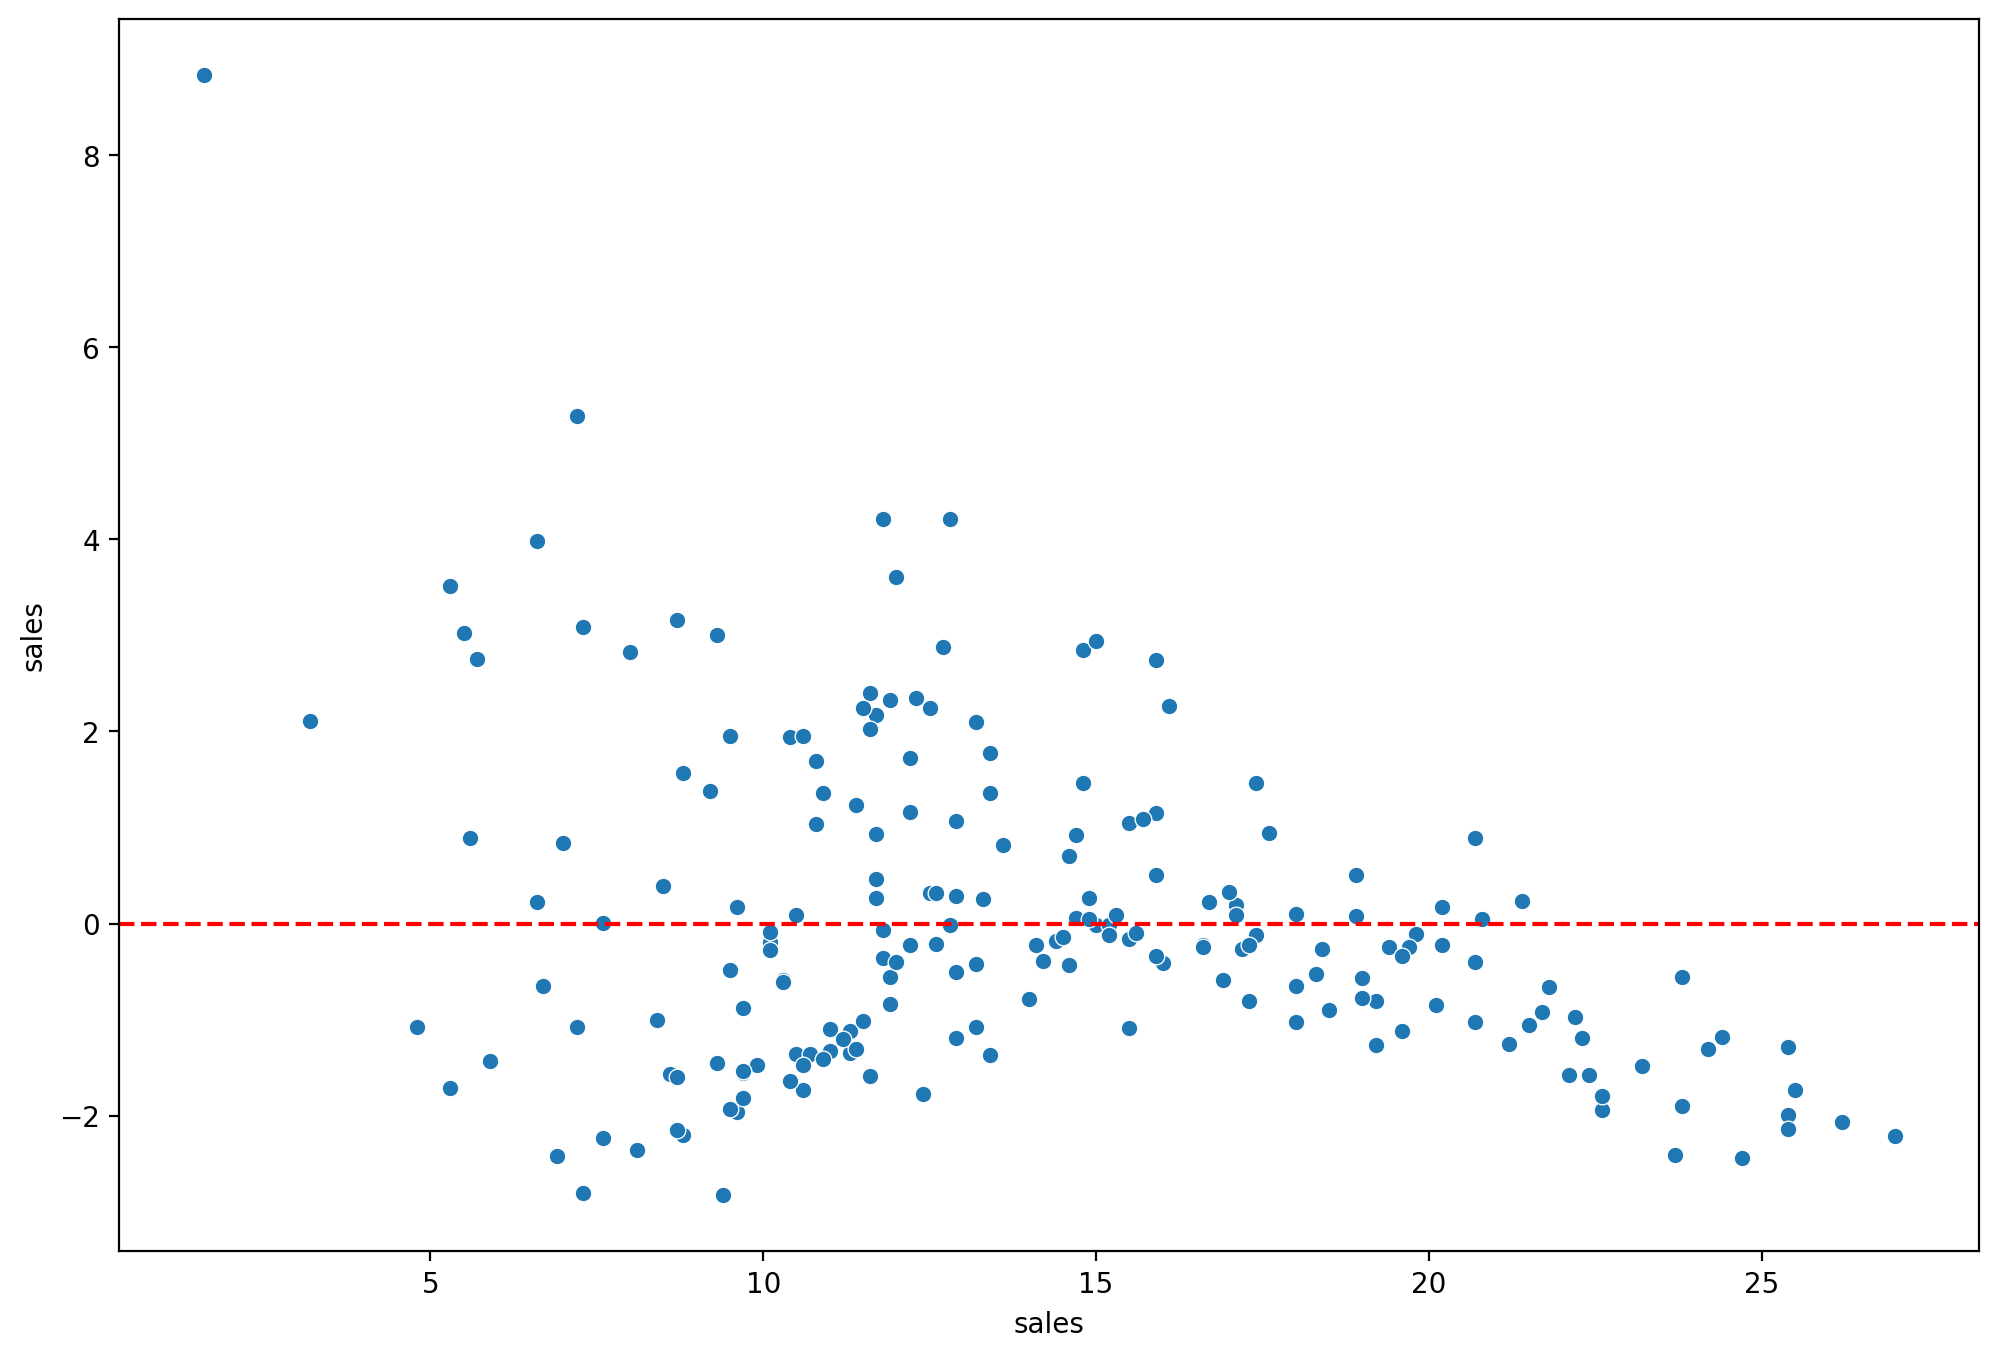

In [148]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(x=y, y=residuals)
plt.axhline(y=0, color='r', linestyle = '--')
plt.show()

In [152]:
df.corr(numeric_only=True)

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


### Предсказание для новых данных
Вспомним - X_test выглядит *в точности* так же, как и новые данные. Так что можно просто вызвать метод **.predict()** для предсказания продаж для новой рекламной компании.

**Допустим, в нашей следующей рекламной кампании мы планируем потратить 149k на рекламу на ТВ, 22k на рекламу по радио и 12k на рекламу в газетах. Сколько единиц товара мы ожидаем продать в результате такой рекламы?**

In [155]:
campaign =[[149, 22, 12]]

In [159]:
df_campaign = pd.DataFrame(campaign, columns=['TV', 'radio', 'newspaper'])

In [161]:
final_model.predict(df_campaign)

array([13.893032])

Насколько это предсказание точное? Очень сложно сказать! Мы знаем только поведение нашей модели на тестовых данных, поэтому нам было важно сначала получить хорошие результаты на тестовых данных прежде, чем обучать модель на всех данных.

---
---

## Сохранение и загрузка модели

In [166]:
from joblib import dump, load

In [168]:
dump(final_model, 'final_sales_model.joblib')

['final_sales_model.joblib']

**Здесь мы взяли обученную модель и сохранили ее в файл**

In [171]:
loaded_model = load('final_sales_model.joblib')

In [173]:
loaded_model.coef_

array([ 0.04576465,  0.18853002, -0.00103749])

In [175]:
loaded_model.predict(df_campaign)

array([13.893032])

**На входе в модель должны подаваться данные той же размерности, которую мы указывали для признаков**

In [178]:
X.shape

(200, 3)

**На вход нашей модели должен подаваться двумерный массив [[]], в нашем случае мы передали одну строку и три колонки.**

---